# Task description

Strimchik online store, which sells computer games all over the world, wants to identify the patterns that determine the success of the game. Historical game sales data, user and expert ratings, genres and platforms (such as Xbox or PlayStation) are available from public sources. This will allow to bid on a potentially popular product and plan advertising campaigns.\
Here is the data up to 2016. Let's say it's December 2016 and a campaign is being planned for 2017. It is necessary to work out the principle of working with data. It doesn't matter if 2017 sales based on 2016 data or 2027 sales based on 2026 data are forecast.\
The abbreviation ESRB (Entertainment Software Rating Board) comes across in the data set - this is an American association that determines the age rating of computer games. The ESRB evaluates game content and assigns it to an appropriate age rating, such as Mature, Toddler, or Teen.

Data Description:

Name - the name of the game\
Platform - platform\
Year_of_Release - year of release\
Genre - game genre\
NA_sales - sales in North America (millions of copies sold)\
EU_sales - sales in Europe (millions of copies sold)\
JP_sales - sales in Japan (millions of copies sold)\
Other_sales - sales in other countries (millions of copies sold)\
Critic_Score - Critics score (maximum 100)\
User_Score - user score (maximum 10)\
Rating - rating from the ESRB (Entertainment Software Rating Board). This association determines the rating of computer games and assigns them an appropriate age category.

# Importing data

In [1]:
import pandas as pd
!pip install missingno
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st
import warnings #hiding warnings for the whole document
warnings.filterwarnings("ignore") #hiding warnings for the whole document

In [2]:
data = pd.read_csv('/datasets/games.csv')
display(data.head(5))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


The preview does not show any anomalies or incorrect data.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Quite a lot of empty rows, as well as columns with incorrect types.

<AxesSubplot:>

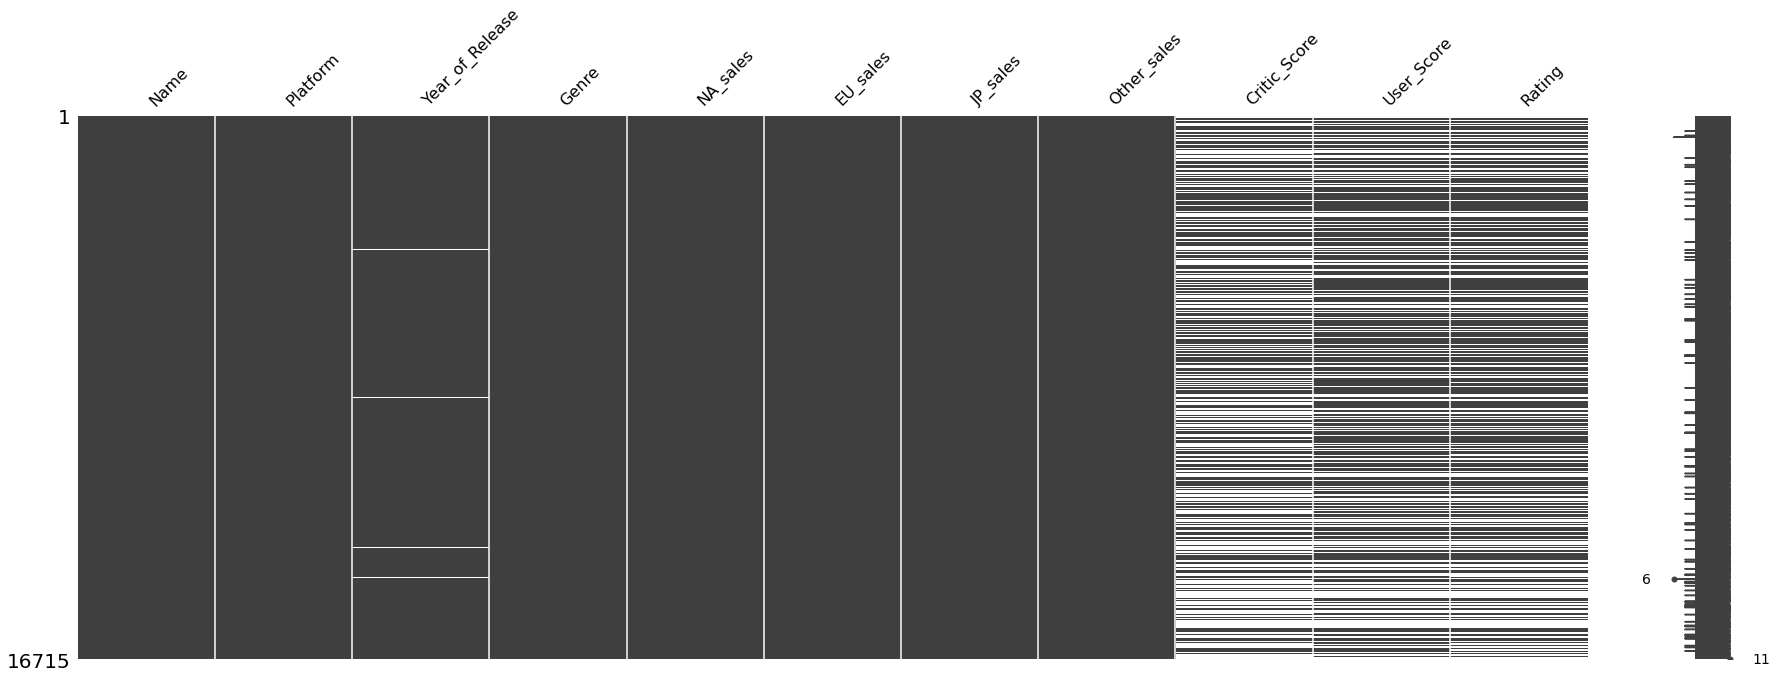

In [4]:
msno.matrix(data, figsize = (30,10))

There are no gaps in most columns, but missing values appear in great numbers in the scores and ratings columns.

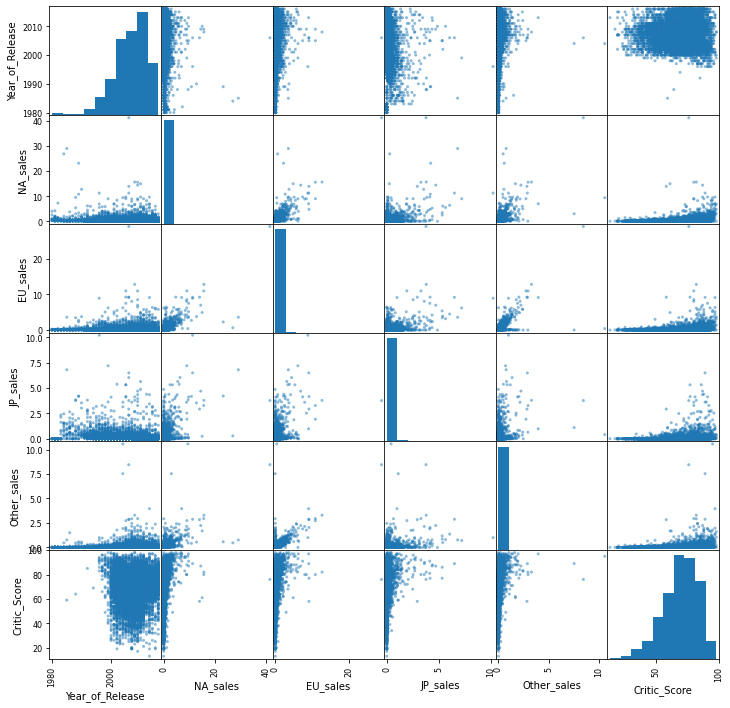

In [5]:
pd.plotting.scatter_matrix(data,figsize=(12, 12));

There is a relationship between some columns - but this relationship should not be considered as direct or inverse, for example:\
almost all games were released after 2000 - and all the numbers also jumped after 2000.\
But the relationship between games sold before 2000 and sales in specific regions is more direct - most of the old games were Japanese and actively distributed there as in source countries, so sales are stable from year to year. A more detailed analysis will be carried out later.

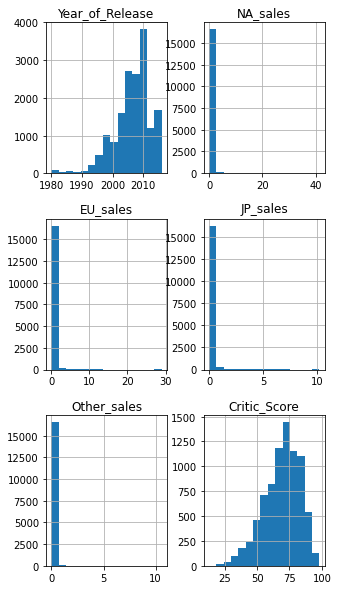

In [6]:
data.hist(figsize=(5, 10), bins = 15);

As stated above, most games were released after 2000, with non-rationed distribution being the norm. Games are released when they're ready, or sometimes even in specific years and months to fit the theme of the game, so there is no "5 games every year" dependency unless it's an annual iteration of FIFA games.

Sales show that there were very few bestsellers - that's why they are bestsellers.

The average rating is at 75 - most games get it.

Subtotal:
- most lines are filled
- column names are not written in lowercase
- not all columns have the correct types (Year_of_Release, User_Score, Critic_Score)

# Data preparation

## Standartisation

### Renaming columns

In [7]:
data.columns = data.columns.str.lower()
print(data.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


### Standartising column values

#### name

In [8]:
data['name'] = data['name'].str.lower()
data['name'] = data['name'].str.replace(':', '')
data['name'] = data['name'].str.translate({ord('.'):None})

#### platform

In [9]:
data['platform'] = data['platform'].str.lower()

## Duplicates

### Explicit duplicates

In [10]:
data.duplicated().sum()

0

Column values were standardized earlier. It looks like there are no absolute duplicates in the values. It is necessary to check each column whether there are implicit duplicates inside and, if necessary, replace them, and then check the explicit duplicates again.

### Implicit duplicates

We have several columns where implicit duplicates can appear: name, platform, genre, rating.

In [11]:
data['name'].value_counts()

need for speed most wanted     12
lego marvel super heroes        9
fifa 14                         9
ratatouille                     9
madden nfl 07                   9
                               ..
tsugunai atonement              1
the lost vikings                1
dollar dash                     1
sound novel tsukuru             1
the sims 3 world adventures     1
Name: name, Length: 11548, dtype: int64

In [12]:
data['platform'].value_counts()

ps2     2161
ds      2151
ps3     1331
wii     1320
x360    1262
psp     1209
ps      1197
pc       974
xb       824
gba      822
gc       556
3ds      520
psv      430
ps4      392
n64      319
xone     247
snes     239
sat      173
wiiu     147
2600     133
nes       98
gb        98
dc        52
gen       29
ng        12
ws         6
scd        6
3do        3
tg16       2
pcfx       1
gg         1
Name: platform, dtype: int64

In [13]:
data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [14]:
data['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

It looks like there are no implicit duplicates in the rows.

In [15]:
print(data.groupby(['name', 'platform', 'rating'])['name'].count().sort_values())

name                        platform  rating
 tales of xillia 2          ps3       T         1
quantum break               pc        M         1
                            xone      M         1
quantum redshift            xb        T         1
quantum theory              ps3       M         1
                                               ..
grid 2                      pc        E         1
sonic the hedgehog          ps3       E10+      2
need for speed most wanted  x360      T         2
madden nfl 13               ps3       E         2
need for speed most wanted  pc        T         2
Name: name, Length: 9945, dtype: int64


Although there were no implicit duplicates in the rows, when outputting data differently, we see that some rows are repeated. They need to be checked.

In [16]:
display(data[(data['name'] == 'madden nfl 13') & (data['platform'] == 'ps3')])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,ps3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,madden nfl 13,ps3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [17]:
display(data[(data['name'] == 'sonic the hedgehog') & (data['platform'] == 'ps3')])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1745,sonic the hedgehog,ps3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,sonic the hedgehog,ps3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+


In [18]:
display(data[(data['name'] == 'need for speed most wanted') & (data['platform'] == 'pc')])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5972,need for speed most wanted,pc,2005.0,Racing,0.02,0.23,0.0,0.04,82.0,8.5,T
11715,need for speed most wanted,pc,2012.0,Racing,0.00,0.06,0.0,0.02,82.0,8.5,T


In [19]:
display(data[(data['name'] == 'need for speed most wanted') & (data['platform'] == 'x360')])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1190,need for speed most wanted,x360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,need for speed most wanted,x360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T


These two cases look weird - we have 2 sets of duplicate ps3 rows with the same year, different sales values, and the ratings are the same. And there are 2 other cases - there are different years of release.\
In the case of different years, this is most likely what they call Remaster - when the game is released with better graphics and other changes so that a new generation will want to play it. Games can technically be considered the same, but in fact, user ratings, sales, and even ratings may change - for example, blood will be drawn better, increasing age limit.

For the first two cases, we can group the rows by all indicators, except for sales - we will sum them up.

In [20]:
data = data.groupby(['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating'],dropna = False)\
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum().reset_index()

In [21]:
display(data[(data['name'] == 'sonic the hedgehog') & (data['platform'] == 'ps3')])
display(data[(data['name'] == 'madden nfl 13') & (data['platform'] == 'ps3')])

,name,platform,year_of_release,genre,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales
12796,sonic the hedgehog,ps3,2006.0,Platform,43.0,4.1,E10+,0.41,0.06,0.04,0.66
12797,sonic the hedgehog,ps3,NaN,Platform,43.0,4.1,E10+,0.00,0.48,0.00,0.00


,name,platform,year_of_release,genre,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales
7677,madden nfl 13,ps3,2012.0,Sports,83.0,5.5,E,2.11,0.23,0.0,0.23


Great - the 'madden' values ​​have collapsed into one line. After filling in the years and categories, we can group values again.

## Cleaning NA values

### name

In some columns, rows can be removed with the usual pre-check - we don't need rows with empty game names, but maybe someone made a mistake and wrote the name of the game in another column?

In [22]:
display(data.loc[data['name'].isna()])

,name,platform,year_of_release,genre,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales
16712,NaN,gen,1993.0,NaN,NaN,NaN,NaN,1.78,0.53,0.03,0.08


We can delete these empty lines - there are only two of them, and they will not give us anything. They are released before the "breakthrough year" and have absolutely no information other than year, sales, and platform.

In [23]:
data = data.dropna(subset = ['name'])
print(data['name'].isna().sum())

0


### year_of_release

You can also check year_of_release - it's likely the information is missing for very old or unpopular games, or just being a common mistake. Age can be checked by platform, popularity by sales.

In [24]:
display(data.loc[data['year_of_release'].isna()])

,name,platform,year_of_release,genre,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales
171,action man-operation extreme,ps,NaN,Action,NaN,NaN,NaN,0.05,0.03,0.00,0.01
187,advance wars days of ruin,ds,NaN,Strategy,86.0,8.7,E10+,0.43,0.12,0.00,0.05
190,adventure,2600,NaN,Adventure,NaN,NaN,NaN,1.21,0.08,0.00,0.01
223,agarest senki re-appearance,ps3,NaN,Role-Playing,NaN,NaN,NaN,0.00,0.00,0.01,0.00
265,air-sea battle,2600,NaN,Shooter,NaN,NaN,NaN,0.91,0.06,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...
16472,yakuza 4,ps3,NaN,Action,78.0,8,M,0.15,0.13,0.63,0.05
16511,yoostar on mtv,x360,NaN,Misc,49.0,tbd,T,0.07,0.00,0.00,0.01
16555,yu yu hakusho dark tournament,ps2,NaN,Fighting,56.0,8.5,T,0.10,0.08,0.00,0.03
16565,yu-gi-oh! 5d's wheelie breakers (jp sales),wii,NaN,Racing,NaN,NaN,NaN,0.00,0.00,0.02,0.00


The theory turned out to be wrong:
- for some games, we can even determine the year of the game through the name - many iterative games, as I mentioned earlier, are released annually, and in order to distinguish between them, publishers put the year of release in the title; and sometimes the games are remakes and are distinguished from the previous ones by the year in the title. You need to be careful with this - for example, the game Cyberpunk 2077 was not released in the future, but simply takes place at that time.
- not all games are unpopular, quite the contrary, but there is no release year. Most likely, this is either a filling error or an initially incomplete data set.

What can be done:
- Make replacements manually by name. Plus, download from the Internet the dates of the release of the consoles or the date when they stopped, in order to eliminate the possibility of the date of the game not falling into the actual existence of the console.
- It is possible to download a list of games from the Internet along with release dates - but we risk falling into a separate task of equalizing titles.
- Can fill empty values using release date on other consoles
- Check manually if games were released in principle on consoles where there is no year

In any case, let's first find the entire list of game titles that do not have a year.

In [25]:
empty_year = data.loc[data['year_of_release'].isna()].sort_values(by = 'name').drop_duplicates('name')
display(empty_year['name'].head(50))
print('Number of null years', data['year_of_release'].isna().sum())

171                     action man-operation extreme
187                        advance wars days of ruin
190                                        adventure
223                      agarest senki re-appearance
265                                   air-sea battle
288               akb1/48 idol to guam de koishitara
301                          alex rider stormbreaker
367                           all-star baseball 2005
378              alone in the dark the new nightmare
511                      aquaman battle for atlantis
747           atsumare! power pro kun no ds koushien
809                                      backbreaker
1038                                 battle vs chess
1125                                     bejeweled 3
1184                            beyond the labyrinth
1193                              big beach sports 2
1218                             bikkuriman daijiten
1243                                      bioshock 2
1395                            blue legend of

Number of null years 269


There are too many lines, and they are too different, and the year is not always present in the title. We will have to try the second method - loading an external dataset, and using the data lying there.

In [26]:
#https://corgis-edu.github.io/corgis/csv/video_games/
games = pd.read_csv('https://corgis-edu.github.io/corgis/datasets/csv/video_games/video_games.csv')
display(games.head(5))
games.columns

,Title,Features.Handheld?,Features.Max Players,Features.Multiplatform?,Features.Online?,Metadata.Genres,Metadata.Licensed?,Metadata.Publishers,Metadata.Sequel?,Metrics.Review Score,...,Length.Main + Extras.Average,Length.Main + Extras.Leisure,Length.Main + Extras.Median,Length.Main + Extras.Polled,Length.Main + Extras.Rushed,Length.Main Story.Average,Length.Main Story.Leisure,Length.Main Story.Median,Length.Main Story.Polled,Length.Main Story.Rushed
0,Super Mario 64 DS,True,1,True,True,Action,True,Nintendo,True,85,...,24.916667,29.966667,25.000000,16,18.333333,14.333333,18.316667,14.500000,21,9.700000
1,Lumines: Puzzle Fusion,True,1,True,True,Strategy,True,Ubisoft,True,89,...,9.750000,9.866667,9.750000,2,9.616667,10.333333,11.083333,10.000000,3,9.583333
2,WarioWare Touched!,True,2,True,True,"Action,Racing / Driving,Sports",True,Nintendo,True,81,...,3.850000,5.666667,3.333333,11,2.783333,1.916667,2.933333,1.833333,30,1.433333
3,Hot Shots Golf: Open Tee,True,1,True,True,Sports,True,Sony,True,81,...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0.000000
4,Spider-Man 2,True,1,True,True,Action,True,Activision,True,61,...,12.766667,17.316667,12.500000,12,10.483333,8.350000,11.083333,8.000000,23,5.333333


Index(['Title', 'Features.Handheld?', 'Features.Max Players',
       'Features.Multiplatform?', 'Features.Online?', 'Metadata.Genres',
       'Metadata.Licensed?', 'Metadata.Publishers', 'Metadata.Sequel?',
       'Metrics.Review Score', 'Metrics.Sales', 'Metrics.Used Price',
       'Release.Console', 'Release.Rating', 'Release.Re-release?',
       'Release.Year', 'Length.All PlayStyles.Average',
       'Length.All PlayStyles.Leisure', 'Length.All PlayStyles.Median',
       'Length.All PlayStyles.Polled', 'Length.All PlayStyles.Rushed',
       'Length.Completionists.Average', 'Length.Completionists.Leisure',
       'Length.Completionists.Median', 'Length.Completionists.Polled',
       'Length.Completionists.Rushed', 'Length.Main + Extras.Average',
       'Length.Main + Extras.Leisure', 'Length.Main + Extras.Median',
       'Length.Main + Extras.Polled', 'Length.Main + Extras.Rushed',
       'Length.Main Story.Average', 'Length.Main Story.Leisure',
       'Length.Main Story.Median', 'Le

The data set above is good for us to determine the release date of Release.Year.\
We cannot take data from player and critic ratings. There are dozens of sites and magazines that publish ratings of games, and we do not know which one was originally taken from our data.\
But we can take the Release.Rating rating, since we know the rating scale - ESRB, and it is quite successfully present in the new data set.\
You need to check if the names of the games match - at least most of them. Let's bring the values to the general ones and check.

In [27]:
games['Title'] = games['Title'].str.lower()
games['Title'] = games['Title'].str.replace(':', '')
games['Title'] = games['Title'].str.replace('.', '')

In [28]:
empty_year_name = empty_year['name']
games_match = games.query('Title in @empty_year_name').loc[:, ['Title', 'Release.Year', 'Release.Rating']]
print(len(games_match['Title'].unique()))

22


As expected, too few game names match. If the data set were larger than 100,000 rows, this method would be less expensive - you could find many data sets and collect a large set from them so that as many names as possible match.\
We don’t have many values with years in the name, so we can afford to manually configure:
- Manually check if games were released at all on a certain console
- If yes, then we will fill in, where possible, the data on the rating and year.

In [29]:
display(empty_year.loc[:,['name', 'platform']])

,name,platform
171,action man-operation extreme,ps
187,advance wars days of ruin,ds
190,adventure,2600
223,agarest senki re-appearance,ps3
265,air-sea battle,2600
...,...,...
16472,yakuza 4,ps3
16511,yoostar on mtv,x360
16555,yu yu hakusho dark tournament,ps2
16565,yu-gi-oh! 5d's wheelie breakers (jp sales),wii


By a random check on the Internet, we see that the games were still released on these consoles. Then you need to fill in the data for the year and rating, using information about other consoles. 99% of the time, games are released in the same year on all consoles, with the exception of exclusives - for example, Horizon Zero Dawn was a Play Station 4 exclusive for a long time, but after several years it was released on PC - or remakes. This is common with new games - so if the release date is before about 2010, you don't have to worry about it.\
Let's fill in the gaps.

In [30]:
print('Number of null years before', data['year_of_release'].isna().sum())

for game in empty_year['name']:
    year = data.loc[data['name'] == game, 'year_of_release'].max()
    data.loc[data['name'] == game,'year_of_release'] = data.loc[data['name'] == game, 'year_of_release'].fillna(year)
    
print('Number of null years after', data['year_of_release'].isna().sum())

Number of null years before 269
Number of null years after 146


We were able to reduce the missing information from 269 rows to 146. You can check again how many titles match after cleaning with the external dataset.

In [31]:
empty_year_name = data.loc[data['year_of_release'].isna(), 'name'].drop_duplicates()

games['Title'] = games['Title']
games_match = games.query('Title in @empty_year_name').loc[:, ['Title', 'Release.Year', 'Release.Rating']]
print(len(games_match['Title'].unique()))
print(games_match['Title'].unique())

5
['wwe smackdown vs raw 2006' 'alex rider stormbreaker' 'rock band'
 'advance wars days of ruin' 'silent hill homecoming']


After clearing the values, only 5 names match. But they can be added.

In [32]:
print('Number of null years before', data['year_of_release'].isna().sum())

for game in empty_year_name:
    year = games.loc[games['Title'] == game, 'Release.Year'].dropna().max()
    data.loc[data['name'] == game,'year_of_release'] = data.loc[data['name'] == game, 'year_of_release'].fillna(year)
    
print('Number of null years after', data['year_of_release'].isna().sum())

Number of null years before 146
Number of null years after 137


In [33]:
with pd.option_context('display.max_rows', None):
    print(data.loc[data['year_of_release'].isna(), 'name'].drop_duplicates())

171                           action man-operation extreme
190                                              adventure
223                            agarest senki re-appearance
265                                         air-sea battle
367                                 all-star baseball 2005
378                    alone in the dark the new nightmare
747                 atsumare! power pro kun no ds koushien
809                                            backbreaker
1184                                  beyond the labyrinth
1193                                    big beach sports 2
1218                                   bikkuriman daijiten
1395                                  blue legend of water
1540                                          breakaway iv
1617               build-a-bear workshop friendship valley
2073                      charm girls club my fashion mall
2074                      charm girls club my fashion show
2128                                  chou soujuu mecha 

As a last step, you can fill in the gaps for those games where there is a year in the title. You can use a condition where there is "20__" at the end, but not all games have the year so - sometimes it is "0_", and sometimes it is "9_" at the end, this can indicate the year, and be just part of the name. Therefore, it is better to fill in manually.

In [34]:
print('Number of null years before', data['year_of_release'].isna().sum())

year_fill = [['nfl gameday 2003', 2003],['all-star baseball 2005', 2005], ['tour de france 2011', 2011], ['football manager 2007', 2007]]

for year in year_fill:
    data.loc[data['name'] == year[0], 'year_of_release'] = data.loc[data['name'] == year[0], 'year_of_release'].fillna(year[1])
    
print('Number of null years after', data['year_of_release'].isna().sum())

Number of null years before 137
Number of null years after 132


132 empty rows in year_of_release out of more than 10000 is quite a good result. You can check for the remaining empty rows and remove them if the sales are low enough - for example, the sum of the sales is less than 0.2. But it is better to check what is considered small sales.

#### Small sales level

<AxesSubplot:>

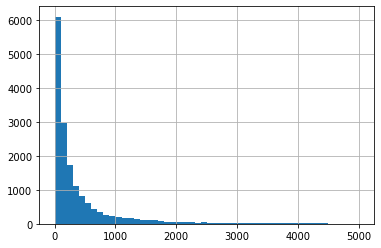

In [35]:
data['total_sales'] = (data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales'])*1000
data['total_sales'].hist(bins=50, range=(0, 5000))

The previous assumption about low sales of 0.2 (200,000 copies) is incorrect - on the contrary, it is one of the most common values. You need to figure out where the outliers are.

In [36]:
data['total_sales'].describe()

count    16712.000000
mean       533.346697
std       1548.324231
min          0.000000
25%         60.000000
50%        170.000000
75%        470.000000
max      82540.000000
Name: total_sales, dtype: float64

We have indicators in 0 sales. We need to check these lines - if there is an error there, or they are really 0, then we do not need these lines - they will only interfere with future analysis.

In [37]:
display(data[data['total_sales'] == 0])

,name,platform,year_of_release,genre,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales,total_sales
4932,g1 jockey 4 2008,ps3,2008.0,Sports,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
11999,score international baja 1000 the official game,ps2,2008.0,Racing,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


This data will not help us - there are only two lines, and because of them all the statistics are shifted. Let's delete them.

In [38]:
data = data[data['total_sales'] > 0]
data['total_sales'].describe()

count    16710.000000
mean       533.410533
std       1548.405896
min         10.000000
25%         60.000000
50%        170.000000
75%        470.000000
max      82540.000000
Name: total_sales, dtype: float64

The minimum figure immediately became 10,000 copies.

<AxesSubplot:>

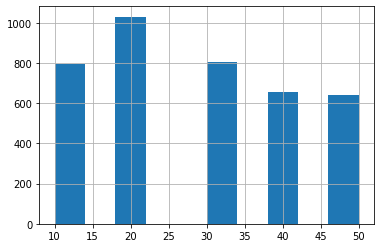

In [39]:
data['total_sales'].hist(range=(10, 50))

On the one hand, the most common sales levels are around 20,000 copies, on the other hand, 10,000 copies is the minimum value of the column. In order not to change the average levels, we will count low sales as sales of 10,000 copies.

In [40]:
data['total_sales'] = data['total_sales'] / 1000
low_sales = min(data['total_sales'])

**year continuation**

In [41]:
data = data.drop(data[(data['total_sales'] < low_sales) & (data['year_of_release'].isna())].index)

print('Amount of null years after', data['year_of_release'].isna().sum())

Amount of null years after 132


Rows were not deleted - there were no minimum sales values. It is possible that after further filling in the values, it will be decided to delete rows for certain sets of indicators. Also, one of the conditions for the study is the use of up-to-date data - but we do not have the opportunity to check the relevance for the missing years. Since sales for this number of rows are a large number:

In [42]:
print(data.loc[data['year_of_release'].isna().sum(), 'total_sales'].sum())

0.08


We'd better not delete these lines until we figure out more information. The last way we can populate the metrics is by using the median of game releases on specific platforms. They have a certain lifespan, and although there is no pattern when certain games are released, there are “shock years” that fall within the lifespan of the platforms.

In [43]:
display(data.groupby('platform')['year_of_release'].median())

platform
2600    1982.0
3do     1995.0
3ds     2013.0
dc      2000.0
ds      2008.0
gb      1997.0
gba     2003.0
gc      2003.0
gen     1993.0
gg      1992.0
n64     1999.0
nes     1986.5
ng      1994.5
pc      2010.0
pcfx    1996.0
ps      1998.0
ps2     2005.0
ps3     2011.0
ps4     2015.0
psp     2009.0
psv     2014.0
sat     1996.0
scd     1994.0
snes    1994.0
tg16    1995.0
wii     2009.0
wiiu    2013.0
ws      2000.0
x360    2010.0
xb      2004.0
xone    2015.0
Name: year_of_release, dtype: float64

Years fall under the logic of platform life - but you need to remove the pc. This is a computer, and games have been released on it constantly - since the 1980s.

In [44]:
platforms = data['platform'].replace('pc', 'empty').unique()

for row in platforms:
    year_median = data.loc[data['platform'] == row, 'year_of_release'].dropna().median()
    data.loc[data['platform'] == row, 'year_of_release'] = data.loc[data['platform'] == row, 'year_of_release'].fillna(year_median)

print('Amount of null years after', data['year_of_release'].isna().sum())
display(data[data['year_of_release'].isna()])

Amount of null years after 4


,name,platform,year_of_release,genre,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales,total_sales
2214,clockwork empires,pc,NaN,Strategy,58.0,3.8,RP,0.00,0.04,0.0,0.00,0.04
5949,homeworld remastered collection,pc,NaN,Strategy,86.0,8.2,E10+,0.00,0.01,0.0,0.00,0.01
13933,tera,pc,NaN,Role-Playing,77.0,6.8,M,0.25,0.12,0.0,0.05,0.42
13966,test drive unlimited 2,pc,NaN,Racing,72.0,5.7,T,0.05,0.11,0.0,0.03,0.19


There are only 4 lines left - we can delete them.

In [45]:
data = data.dropna(subset = ['year_of_release'])
print('Amount of null years after', data['year_of_release'].isna().sum())

Amount of null years after 0


### rating

In [46]:
data['rating'].value_counts()

E       3989
T       2960
M       1562
E10+    1419
EC         8
K-A        3
RP         2
AO         1
Name: rating, dtype: int64

The rating column uses ESRB values, an American association. There are the following values:

Titles rated E (Everyone) have content that may be suitable for persons ages 6 and older. Titles in this category may contain minimal cartoon, fantasy or mild violence and/or infrequent use of mild language.

Titles rated E10+ (Everyone 10 and older) have content that may be suitable for persons ages 10 and older. Titles in this category may contain more cartoon, fantasy or mild violence, mild language, and/or minimal suggestive themes.

Titles rated T (Teen) have content that may be suitable for ages 13 and older. Titles in this category may contain violence, suggestive themes, crude humor, minimal blood, simulated gambling, and/or infrequent use of strong language.

Titles rated M (Mature) have content that may be suitable for persons 17 years and older. Titles in this category may contain intense violence, blood and gore, sexual content, and/or strong language.

Titles rated AO (Adults Only) have content that should only be played by persons 18 years and older. Titles in this category may include prolonged scenes of intense violence and/or graphic sexual content and nudity.

Title listed as RP (Rating Pending) has been submitted to the ESRB and is awaiting final rating. (This symbol appears only in advertising prior to a game’s release.)

Ratings E10, T are the same in age categories, and they can be grouped into one type, while M and AO fall into the "adult" category, they can also be distinguished separately.

Some ratings are very old - K-A is most likely kids-adults, that is, E.\
EC is 'Early childhood'. Removed from the list due to infrequent use. Can be categorized as E. Let's combine the categories in the main column, and also create a separate column to categorize "minimum age of use", and use it in the future. Games with RP can be checked line by line and, if sales are low, removed.

In [47]:
data['rating'] = data['rating'].replace('EC','E')
data['rating'] = data['rating'].replace('K-A','E')
data['rating'].value_counts()

E       4000
T       2960
M       1562
E10+    1419
RP         2
AO         1
Name: rating, dtype: int64

In [48]:
display(data[data['rating'] == 'RP'])

,name,platform,year_of_release,genre,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales,total_sales
13627,supreme ruler cold war,pc,2011.0,Strategy,63.0,6.8,RP,0.0,0.03,0.0,0.01,0.04
16276,wrc fia world rally championship,pc,2005.0,Racing,65.0,NaN,RP,0.0,0.01,0.0,0.00,0.01


Sales are low and the total number of lines is less than 5. These lines can be deleted.

In [49]:
data = data[data['rating'] != 'RP']

Now let's add categories.

In [50]:
def categorized_rating(rating):
    try:
        if 'K-A' in rating or 'EC' in rating or 'E' in rating:
            return 'E'
        elif 'M' in rating or 'AO' in rating:
            return 'M'
        elif 'T' in rating or 'E10+' in rating:
            return 'E10+'
        else:
            return null
    except:
        pass
    
data['rating_general'] = data['rating'].apply(categorized_rating)
print(data['rating_general'].value_counts())

E       5419
E10+    2960
M       1563
Name: rating_general, dtype: int64


Let's check on the Internet whether the rating was set for different games - maybe they are too old and do not have it?

In [51]:
empty_rating = data.loc[data['rating'].isna()]
display(empty_rating.loc[:5,['name','platform', 'year_of_release']])

,name,platform,year_of_release
0,beyblade burst,3ds,2016.0
1,fire emblem fates,3ds,2015.0
2,frozen olaf's quest,3ds,2013.0
3,frozen olaf's quest,ds,2013.0
4,haikyu!! cross team match!,3ds,2016.0


frozen olaf's quest was released in 2013, but the game is available on the official rating site. Assigned category E - for all. So the problem is not in the old age of the game, but in the usual lack of information.

Let's fill in the rating column in the same way as for year, but add another slice for the year.

In [52]:
print('Amount of null ratings before', data['rating'].isna().sum())

for game in empty_rating['name']:
    rating = data.loc[data['name'] == game, 'rating_general'].dropna().max()
    data.loc[data['name'] == game,'rating'] = data.loc[data['name'] == game, 'rating'].fillna(rating)

print('Amount of null ratings after', data['rating'].isna().sum())

Amount of null ratings before 6762
Amount of null ratings after 6321


It turned out to reduce the number of empty lines by about 450 pieces. Let's now try to use an external dataset to further fill in the gaps.

In [53]:
empty_rating = data.loc[data['rating'].isna()].drop_duplicates(['name','platform'])
empty_rating_name = empty_rating['name']

games_match_rating = games.query('Title in @empty_rating_name').loc[:, ['Title','Release.Year', 'Release.Rating']]
print(len(games_match_rating['Title'].unique()))

39


39 game names match - given what we've seen before - some games don't have the same ratings or are duplicated - it's best not to merge the ratings. Before further work, we will carry out a general grouping of the table according to the values that have appeared.

In [54]:
data = data.groupby(['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating', 'rating_general'],dropna = False)\
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']].sum().reset_index()

Why does this column have so many missing values? They might not have been filled out, and the games might not have been released in the US or Canada, and, accordingly, the rating for them was not affixed.

In [55]:
display(data.loc[data['rating'].isna(), ['na_sales', 'total_sales']].sum())

na_sales       1132.21
total_sales    2617.60
dtype: float64

This is not so - if not all, then some of the games were definitely released in America. Most likely, this is a human error when the data simply did not fill out. In order for the data not to change the result, fill in the empty values with the value 'unknown'

In [56]:
data['rating'] = data['rating'].fillna('unknown')

### critic_score, user_score

We can't fill in the columns with scores with either medians or averages - it's not clear what source the scores come from (which magazine/shop), they also vary by market and by game within a series of games. Actually, this may be the reason for the empty lines - the estimates in the source were simply not set. You need to check what values are in these columns.

In [57]:
print(data.groupby('critic_score')['critic_score'].count())

critic_score
13.0     1
17.0     1
19.0     6
20.0     3
21.0     1
        ..
94.0    37
95.0    16
96.0    18
97.0    11
98.0     4
Name: critic_score, Length: 82, dtype: int64


Indicators are within the normal range - no errors or other inconsistencies are visible, the boundaries of 0-100 are respected.

In [58]:
print(data.groupby('user_score')['user_score'].count())

user_score
0         1
0.2       2
0.3       2
0.5       2
0.6       2
       ... 
9.4      11
9.5       6
9.6       2
9.7       1
tbd    2424
Name: user_score, Length: 96, dtype: int64


There are two values ​​in the user_score column that are not normal - 0 and some tbd. A rating of 0 is extremely unlikely - let's check it first.

In [59]:
display(data[data['user_score'] == '0'])

,name,platform,year_of_release,genre,critic_score,user_score,rating,rating_general,na_sales,eu_sales,jp_sales,other_sales,total_sales
8965,my little pony pinkie pie's party,ds,2008.0,Adventure,NaN,0,E,E,0.66,0.0,0.0,0.06,0.72


It seems that this meant that there is simply no user rating - in this case, it is better to replace this value with null.

In [60]:
data['user_score'] = data['user_score'].replace('0', np.nan)
display(data[data['user_score'] == '0'])

,name,platform,year_of_release,genre,critic_score,user_score,rating,rating_general,na_sales,eu_sales,jp_sales,other_sales,total_sales


Now let's see what this tbd score is. Google says that it means "to be declared" - if it's simpler, it means "no evaluation yet". You have to check for the critics' scores.

In [61]:
display(data[data['user_score'] == 'tbd'].head(10))

,name,platform,year_of_release,genre,critic_score,user_score,rating,rating_general,na_sales,eu_sales,jp_sales,other_sales,total_sales
7,007 quantum of solace,ds,2008.0,Action,65.0,tbd,T,E10+,0.11,0.01,0.0,0.01,0.13
19,10 minute solution,wii,2010.0,Sports,NaN,tbd,E,E,0.06,0.01,0.0,0.01,0.08
24,1001 touch games,ds,2011.0,Action,NaN,tbd,E,E,0.11,0.16,0.0,0.04,0.31
25,101-in-1 explosive megamix,ds,2008.0,Puzzle,46.0,tbd,E,E,0.05,0.12,0.0,0.02,0.19
27,101-in-1 sports megamix,ds,2010.0,Sports,NaN,tbd,E10+,E,0.08,0.00,0.0,0.01,0.09
28,101-in-1 sports party megamix,wii,2010.0,Sports,41.0,tbd,E10+,E,0.02,0.00,0.0,0.00,0.02
88,4x4 evo 2,gc,2002.0,Racing,56.0,tbd,E,E,0.11,0.03,0.0,0.00,0.14
90,4x4 evolution,ps2,2001.0,Racing,64.0,tbd,E,E,0.16,0.12,0.0,0.04,0.32
97,50 classic games,ds,2009.0,Misc,NaN,tbd,E,E,0.50,0.00,0.0,0.04,0.54
102,7 wonders ii,ds,2009.0,Puzzle,60.0,tbd,E,E,0.13,0.15,0.0,0.03,0.31


Some well-selling games are missing player ratings - can it be possible to remove lines with a small number of sales, no rating, critic and user ratings?

In [62]:
display(data[(data['total_sales'] == low_sales) & ((data['user_score'].isna()) | (data['user_score'] == 'tbd')) & (data['critic_score'].isna())])

,name,platform,year_of_release,genre,critic_score,user_score,rating,rating_general,na_sales,eu_sales,jp_sales,other_sales,total_sales
18,1/2 summer +,psp,2013.0,Adventure,NaN,NaN,unknown,NaN,0.0,0.00,0.01,0.0,0.01
83,4 play collection - dark mysteries,pc,2014.0,Misc,NaN,NaN,unknown,NaN,0.0,0.01,0.00,0.0,0.01
96,50 classic games,3ds,2012.0,Misc,NaN,NaN,E,NaN,0.0,0.01,0.00,0.0,0.01
106,7'scarlet,psv,2016.0,Adventure,NaN,NaN,unknown,NaN,0.0,0.00,0.01,0.0,0.01
135,aa megami-samaa,ps2,2007.0,Adventure,NaN,NaN,unknown,NaN,0.0,0.00,0.01,0.0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16445,xi coliseum,psp,2006.0,Puzzle,NaN,NaN,unknown,NaN,0.0,0.00,0.01,0.0,0.01
16484,yattaman wii bikkuridokkiri machine de mou rac...,wii,2008.0,Racing,NaN,NaN,unknown,NaN,0.0,0.00,0.01,0.0,0.01
16635,zero no tsukaima maigo no period to ikusen no ...,ps2,2008.0,Adventure,NaN,NaN,unknown,NaN,0.0,0.00,0.01,0.0,0.01
16642,zettai kaikyuu gakuen eden with roses and phan...,psv,2016.0,Adventure,NaN,NaN,unknown,NaN,0.0,0.00,0.01,0.0,0.01


Approximately 520 lines fall under "no scores, small sales". Or maybe this is a common thing for such sales volumes? Let's check.

In [63]:
print(data[data['total_sales'] == low_sales]['name'].count())

794


There are few small sales in principle, but more than 50% do not contain reviews from critics and users at the same time. In this case, we can delete the lines with the conditions above, and also if the game was released before, for example, 2005 - yes, even though then there was not enough computer power to make games a masterpiece, but this did not stop manufacturers. What has changed since then is exactly how and what kind of games are created - there has been a shift towards "casual", that is, simpler games. And what was popular then for that generation may not be popular now.

In [64]:
data = data.drop(data[((data['user_score'].isna()) | (data['user_score'] == 'tbd')) & (data['total_sales'] == low_sales) & (data['year_of_release'] <2006) & (data['critic_score'].isna())].index)
print(data[data['total_sales'] == low_sales]['name'].count())

746


Let's also replace the tbd value with null - otherwise we won't be able to change the column type.

In [65]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)
display(data[data['user_score'] == 'tbd'])

,name,platform,year_of_release,genre,critic_score,user_score,rating,rating_general,na_sales,eu_sales,jp_sales,other_sales,total_sales


We have removed lines that do not contain useful information.\
Earlier, we indicated that after filling in the rows, we can again group the table by all values, except for sales, which will be summed up. Let's group and check the new table.

In [66]:
data = data.groupby(['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating', 'rating_general'],dropna = False)\
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']].sum().reset_index()

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16655 entries, 0 to 16654
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16655 non-null  object 
 1   platform         16655 non-null  object 
 2   year_of_release  16655 non-null  float64
 3   genre            16655 non-null  object 
 4   critic_score     8129 non-null   float64
 5   user_score       7582 non-null   object 
 6   rating           16655 non-null  object 
 7   rating_general   9929 non-null   object 
 8   na_sales         16655 non-null  float64
 9   eu_sales         16655 non-null  float64
 10  jp_sales         16655 non-null  float64
 11  other_sales      16655 non-null  float64
 12  total_sales      16655 non-null  float64
dtypes: float64(7), object(6)
memory usage: 1.7+ MB


## Changing types

We only have two columns with the wrong types.

In [68]:
data['user_score'] = data['user_score'].astype('float64')
data['year_of_release'] = data['year_of_release'].astype('int32')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16655 entries, 0 to 16654
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16655 non-null  object 
 1   platform         16655 non-null  object 
 2   year_of_release  16655 non-null  int32  
 3   genre            16655 non-null  object 
 4   critic_score     8129 non-null   float64
 5   user_score       7582 non-null   float64
 6   rating           16655 non-null  object 
 7   rating_general   9929 non-null   object 
 8   na_sales         16655 non-null  float64
 9   eu_sales         16655 non-null  float64
 10  jp_sales         16655 non-null  float64
 11  other_sales      16655 non-null  float64
 12  total_sales      16655 non-null  float64
dtypes: float64(7), int32(1), object(5)
memory usage: 1.6+ MB


Subtotal:
- columns are reduced to lowercase
- the names of the games are reduced to the same denominator - removed colons, dots, reduced to lower case
- replacements were made where possible - year, rating. There are voids left in them that cannot be filled quickly - external data sources will not help, since the names very often do not match, and the ratings and years depend on the device on which the game was released - you cannot simply search for matches by name, because manufacturers do not always different names. You cannot fill in the values in the rating columns - the rating base is unknown.
- removed rows that will not help or affect the analysis in any way - empty names, sales, rows with missing data (by years, combinations of ratings and sales - the lowest sales are used as an additional filter)
- added columns total_sales and rating_general
- tables are grouped by duplicate rows - some values were separated for some reason
- changed types for two columns

# Exploratory data analysis

## Games by years

array([<AxesSubplot:xlabel='year_of_release'>], dtype=object)

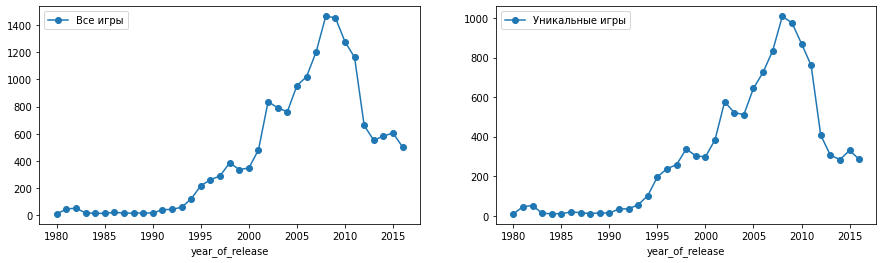

In [69]:
game_amount_group = data.groupby('year_of_release')['name'].count().reset_index()
unique_game_amount_group = data.drop_duplicates(subset = ['name']).groupby('year_of_release')['name'].count().reset_index()

fig, axes2 = plt.subplots(nrows=1,ncols=2,figsize=(15,4))
# plot first pandas frame in subplot style

game_amount_group.plot(ax = axes2[0],subplots=True,x='year_of_release', y = 'name', style='o-', label='Все игры')
unique_game_amount_group.plot(ax = axes2[1],subplots=True,x='year_of_release', y = 'name', style='o-', label='Уникальные игры')

Above are two graphs - with all the games, as well as with unique game names. The graphics are quite a bit different. The analysis can be carried out according to the schedule with all names.\
Until 2000, games were rarely released - up to 400 a year - after that, at least 600 games were released on average per year. As mentioned earlier, it makes no sense to consider games before 2000, and even before 2005 - as you can see from the graph, in 2005 there was an absolute boom in games, and every year more and more of them came out, but after about 2011 there was a drop in the total number of games released in year.

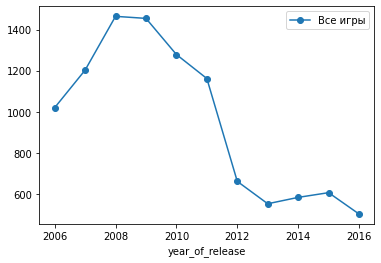

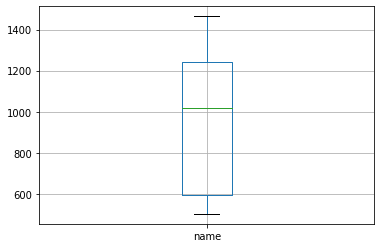

count      11.000000
mean      953.454545
std       379.192132
min       502.000000
25%       594.500000
50%      1020.000000
75%      1241.000000
max      1465.000000
Name: name, dtype: float64

In [70]:
data_actual = data[data['year_of_release'] > 2005]
game_amount_group= game_amount_group[game_amount_group['year_of_release'] > 2005]

game_amount_group.plot(x='year_of_release', y = 'name', style='o-', label='Все игры')
plt.show()
game_amount_group.boxplot(column='name') 
plt.show()
game_amount_group['name'].describe()

One of the reasons for this growth and fall may be the release of new consoles - all manufacturers abruptly release games on new media, and then the novelty subsides, and games are released less frequently. But it depends on which consoles are in the database, as well as release dates and best-selling sales. In 2011, for example, a game was released that is still popular - it could fill the entire space with itself, demotivating other manufacturers.\
Another reason may be the improvement in the quality of games - in order to release a popular, and most importantly good game, it now takes more time. If we had the names of the manufacturers, we could track how much time passes between each game that was published by a particular company.\
First, let's trace the life cycle of platforms.

## Platforms

### Life cycle

AxesSubplot(0.125,0.125;0.775x0.755)


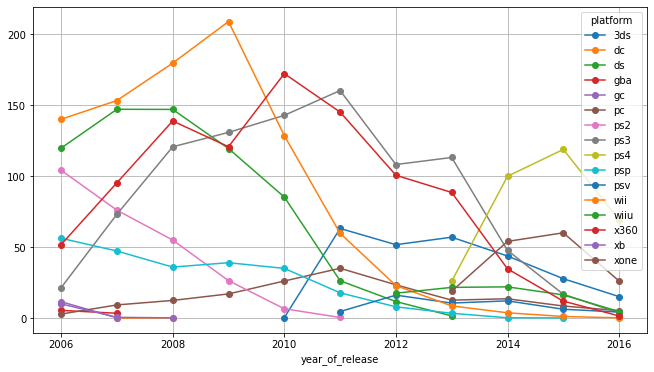

In [71]:
print(data_actual.pivot_table(index='year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum').plot(style='o-', figsize=(11, 6), grid=True, legend = True));

We see a huge number of platforms - some already ceased to exist after a certain year, some replaced the previous ones, but for some time they existed together. Although the graph clearly shows approximate lifetimes, we need to understand how often new consoles are launched - well, or how long they just exist. To do this, we use the entire period from the database, after deleting the 'pc' platform, as for previous analyzes - this is a personal computer, games will always be released on it.

In [72]:
platform_life = data[data['platform'] != 'pc'].groupby('platform').agg({'year_of_release': ['min', 'max']})
platform_life['total_life'] = platform_life['year_of_release']['max'] - platform_life['year_of_release']['min']
platform_life = platform_life.sort_values(by = 'total_life')
print(platform_life)

         year_of_release       total_life
                     min   max           
platform                                 
gg                  1992  1992          0
pcfx                1996  1996          0
tg16                1995  1995          0
3do                 1994  1995          1
scd                 1993  1994          1
ws                  1999  2001          2
ng                  1993  1996          3
ps4                 2013  2016          3
xone                2013  2016          3
wiiu                2012  2016          4
gen                 1990  1994          4
sat                 1994  1999          5
psv                 2011  2016          5
gc                  2001  2007          6
3ds                 2010  2016          6
gba                 2000  2007          7
n64                 1996  2004          8
xb                  2000  2008          8
snes                1990  1999          9
ps                  1994  2003          9
wii                 2006  2016    

The data is very varied - with some, like the ps3 and ps4, being part of the series - and if the ps4 has a lifespan of 3 years according to the table above, it's because the maximum date is 2016. But we can't just remove the rows where the year is 2016 - it would be better to reduce the maximum year by 1. This will allow us to weed out games that have existed for less than 1 year.

In [73]:
platform_life.columns = ['min_year', 'max_year', 'lifetime']
platform_life['max_year'] = platform_life['max_year'] - 1
platform_life['lifetime'] = platform_life['lifetime'] - 1
platform_life = platform_life[platform_life['lifetime'] > 0]
print(platform_life.sort_values(by = 'max_year'))

          min_year  max_year  lifetime
platform                              
nes           1983      1993        10
gen           1990      1993         3
ng            1993      1995         2
sat           1994      1998         4
snes          1990      1998         8
ws            1999      2000         1
gb            1988      2000        12
2600          1980      2001        21
ps            1994      2002         8
n64           1996      2003         7
gc            2001      2006         5
gba           2000      2006         6
dc            1998      2007         9
xb            2000      2007         7
ps2           2000      2010        10
ds            1985      2012        27
psp           2004      2014        10
psv           2011      2015         4
wii           2006      2015         9
wiiu          2012      2015         3
ps3           2005      2015        10
xone          2013      2015         2
x360          2005      2015        10
ps4           2013      2

count    25.00000
mean      7.80000
std       5.88076
min       1.00000
25%       4.00000
50%       7.00000
75%      10.00000
max      27.00000
Name: lifetime, dtype: float64


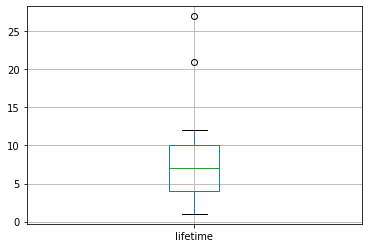

In [74]:
print(platform_life['lifetime'].describe())
platform_life.boxplot(column='lifetime') 
plt.show()

On average, consoles 'live' for 4 to 10 years. If we consider that we removed one year in order to preserve the platforms that still existed in 2016, and not just remove them, then the average life is from 5 to 11 years. And this does not depend on when the console was launched - before or after 2005. Even if we weren't in 2022, judging by the longevity of some consoles, further cleanup could be done - the xone and ps4 are the newest versions of the x360 and ps3 consoles, as are the wiiu and psv. They were all released after 2010, so they can also be removed from the analysis.

count    20.000000
mean      8.950000
std       6.030405
min       1.000000
25%       5.750000
50%       8.500000
75%      10.000000
max      27.000000
Name: lifetime, dtype: float64


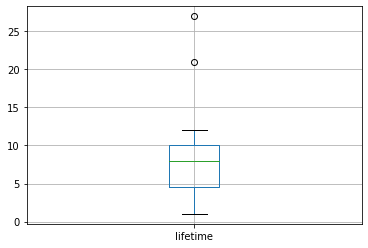

          min_year  max_year  lifetime
platform                              
2600          1980      2001        21
nes           1983      1993        10
ds            1985      2012        27
gb            1988      2000        12
gen           1990      1993         3
snes          1990      1998         8
ng            1993      1995         2
ps            1994      2002         8
sat           1994      1998         4
n64           1996      2003         7
dc            1998      2007         9
ws            1999      2000         1
gba           2000      2006         6
ps2           2000      2010        10
xb            2000      2007         7
gc            2001      2006         5
psp           2004      2014        10
ps3           2005      2015        10
x360          2005      2015        10
wii           2006      2015         9


In [75]:
print(platform_life.loc[platform_life['min_year'] <2010, 'lifetime'].describe())
platform_life[platform_life['min_year'] <2013].boxplot(column='lifetime')
plt.show()
print(platform_life[platform_life['min_year'] <2010].sort_values(by='min_year'))

Now we can say for sure that the average life of consoles is from 6 to 11 years. New types of consoles, which statistically have a short lifespan, but in fact will soon replace the previous versions, we have removed to equalize the averages.\
Moreover, for newer consoles, the expiration date is getting longer and longer - if earlier the average life was about 7, now it is approaching 10. We can assume that any console released after 2010 will live at least 10 years - and if at the moment she is only, for example, 3 years old, then she still has 7 years of life left.

In [76]:
lifetime = 10

### Sales by platform

The period we can use to follow the trends is from 2005 to 2016. We can't automatically take the period before 2010 as we would remove potential platforms that way.

The current period is the period from the start of the introduction of new platforms until 2016, that is, from 2013.

Soon we will sort out the "star" consoles - those that will definitely not go away over the next few years, that is, games on them will continue to be released, and after a certain number of years their next variations will appear. Of course, it is impossible to predict the appearance of a completely new console, but you can consider that if suddenly a popular manufacturer releases a new console, it could become a hit. But first you need to create a list of manufacturers of these same consoles.

In [77]:
producers = [['nintendo',['3ds', 'ds', 'wii', 'n64', 'gc', 'nes', 'gba', 'snes', 'wiiu', 'gb', 'gg']],
             ['sony',['ps3', 'ps', 'ps2', 'psp', 'ps4', 'psv']],
             ['mixed',['pc']],
             ['microsoft',['x360', 'xb', 'xone']],
             ['atari',['2600']],
             ['sega',['sat', 'dc', 'scd']],
             ['snk',['ng']],
             ['unknown',['gen']],
             ['nec',['pcfx', 'tg16']],
             ['3do',['3do']],
             ['bandai',['ws']]]

def producer(game):
    for row in range(len(producers)):
        if game in producers[row][1]:
            return producers[row][0]

In [78]:
data['platform_producer'] = data['platform'].apply(producer)
print(data['platform_producer'].value_counts())

sony         6707
nintendo     6245
microsoft    2326
mixed         962
sega          231
atari         133
unknown        27
snk            12
bandai          6
nec             3
3do             3
Name: platform_producer, dtype: int64


We have added sorting by platform manufacturers. Sometimes a game becomes popular precisely because of the platform, because a large number of people already own it. Let's create a division of years according to relevance - this will help us in further sorting.

In [79]:
# Data after 2012 is actual
data_actual = data[data['year_of_release'] > 2012]
# Data after 2005 is to track trends
data_trends = data[data['year_of_release'] > 2005]

In [80]:
platform_total_sales = data_trends.groupby(['platform', 'platform_producer']).agg({'total_sales':['sum'],'year_of_release':['min','max']})
platform_total_sales.columns = ['total_sales', 'min_year', 'max_year']
platform_total_sales['lifetime'] = platform_total_sales['max_year'] - platform_total_sales['min_year']

display(platform_total_sales.sort_values(by='total_sales'))

,,total_sales,min_year,max_year,lifetime
platform,platform_producer,,,,
dc,sega,0.06,2007,2008,1
gba,nintendo,8.86,2006,2007,1
xb,microsoft,10.77,2006,2008,2
gc,nintendo,11.82,2006,2007,1
psv,sony,54.07,2011,2016,5
wiiu,nintendo,82.19,2012,2016,4
xone,microsoft,159.32,2013,2016,3
pc,mixed,166.42,2006,2016,10
psp,sony,243.15,2006,2015,9


We can't just take platforms with the largest sales - we need to take platforms that at the time of 2016 had a lifespan of 10 years or less, that is, the platforms currently operating and their substitutes. It is this data that will allow us to predict the popularity of platforms.

In [81]:
leading_platform_total_sales = platform_total_sales[(platform_total_sales['max_year'] == 2016) & (platform_total_sales['lifetime'] < 11)].reset_index()
display(leading_platform_total_sales.sort_values(by = 'total_sales', ascending = False))

,platform,platform_producer,total_sales,min_year,max_year,lifetime
7,x360,microsoft,962.20,2006,2016,10
2,ps3,sony,939.46,2006,2016,10
5,wii,nintendo,907.51,2006,2016,10
3,ps4,sony,314.14,2013,2016,3
0,3ds,nintendo,259.00,2010,2016,6
1,pc,mixed,166.42,2006,2016,10
8,xone,microsoft,159.32,2013,2016,3
6,wiiu,nintendo,82.19,2012,2016,4
4,psv,sony,54.07,2011,2016,5


In [82]:
leading_platforms = leading_platform_total_sales['platform'].unique()

In [83]:
top_platform = 'x360'

We finally got a list of potential "winner" platforms - games released on those platforms will be popular - as well as the most popular platform at the moment. This is x360.\
Let's add a column with leading platforms to the data, update the necessary data, and filter the new chart by the new column.

In [84]:
def leading_platform(platform):
    for row in leading_platforms:
        if platform == row:
            return True
        
data['leading_platform'] = data['platform'].apply(leading_platform).fillna(False)

In [85]:
# Actual data after 2012 with leading platforms only
data_actual = data[(data['year_of_release'] > 2012) & (data['leading_platform'] == True)]
# Trends data after 2005 with leading platforms only
data_trends = data[(data['year_of_release'] > 2005) & (data['leading_platform'] == True)]

Data is updated.

<AxesSubplot:xlabel='year_of_release'>

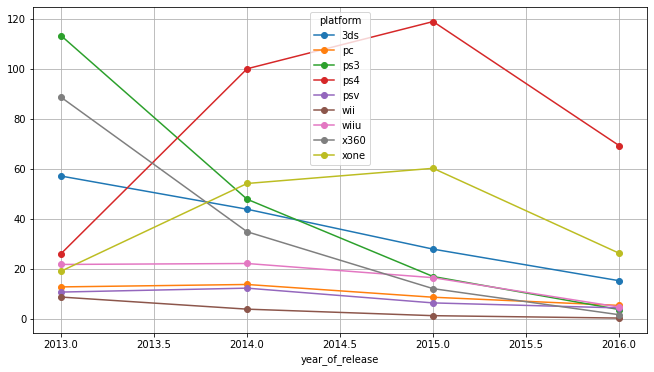

In [86]:
data_actual.pivot_table(index='year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum').plot(style='o-', figsize=(11, 6), grid=True, legend = True)

We're seeing yearly sales of consoles like the ps3, x360 and wii fall somewhere around the first year of next generation consoles as the focus shifts to the new ps4, xone and wiiu consoles. 3ds is also starting to fall - one can assume that a new console will be released soon - this is a separate type of portable consoles, their competitor is psv, which was less popular than 3ds. Most likely, due to low sales, psv will not continue - the main income is brought by home playstation consoles.\
This means that in addition to 10 years of life, we can say that the new consoles of these lines will be popular, as they are:
- representatives of the consoles of the three largest manufacturers
- the most popular lines of consoles from these manufacturers
- also likely the emergence of a new console-successor 3ds.

Let's look at the averages for the 'star' platforms.

,platform,lifetime
0,3ds,6
1,pc,10
2,ps3,10
3,ps4,3
4,psv,5
5,wii,10
6,wiiu,4
7,x360,10
8,xone,3


(0.0, 1.8)

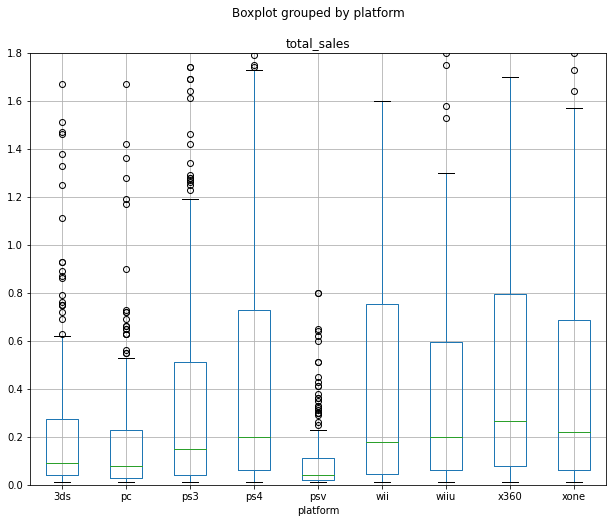

In [87]:
display(leading_platform_total_sales.loc[:, ['platform', 'lifetime']])
data_actual.boxplot(column='total_sales', by='platform', figsize=(10,8))
plt.ylim(0,1.8)

As we stated earlier:
1) 3ds doesn't have an heir yet. Its rival psv has lower sales and they are the same age. 3ds may live on for a while and then get an heir, but games on psv will not be popular.\
2) The ps3 is already on average selling less than the ps4 and is practically below its x360 competitor - both consoles are the same generation. Games on ps3 and x360 will soon be gone, and it is better not to count on them.\
3) ps4 is the future of ps3. For the current period, he has already bypassed the ps3. We can safely say that games on these platforms will soon be sold more actively than on ps3.\
4) wii and wiiu - the new generation - are in a slightly different position. The new console has not yet surpassed the previous one in sales, but will soon catch up, although it has only been around for 4 years against 10. We can assume that games on the wiiu will be more popular than any game on the wii.\
5) PC sales seem to be low, but that's because we're comparing them to the overall sales of similar games on console - in fact, many console games come out on PC, and sometimes even the other way around. It all depends on where the game originally came out - after all, not everyone can have consoles, and vice versa - if the game is very demanding in terms of computer power, people can buy a console specifically so as not to worry about the performance on the computer. Therefore, the pc platform is extremely dependent on performance requirements. Computers change less often, so many drop out of new games, which demotivates people to play games in general, or motivates them to switch to consoles.

We must not forget that many games are ported to new consoles - sometimes for free (if you have a ps3 version, for example, you will get it on ps4 by simply logging into your account) to fill a gap in offers until games with new graphic features.

### Scores and sales

Let's look at the general dependency first.

#### User scores

(0.0, 40.0)

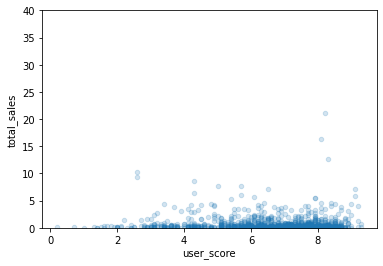

In [88]:
data_actual.plot(x='user_score',y='total_sales',kind='scatter', alpha = 0.2)
plt.ylim(0,40)

There is a correlation between the level of user ratings and overall sales - the fact that sales of up to 2.5 million still remain at high ratings is due to the overall distribution of sales.

In [89]:
print('Correlation between user scores and sales', data_actual['user_score'].corr(data_actual['total_sales']))

Correlation between user scores and sales -0.0026180307181862864


But according to the calculation of the correlation coefficient, there is no connection. Again, this may be due to the fact that a sufficiently large number of sales are in the zone before 2.5. This is logical - each game cannot sell 10 million copies just because users rated it highly enough. Some games with ratings of 9 and above have sold less than 1 million copies - this can happen for many reasons:
- sometimes free-to-download games get an incredible number of downloads and get the highest scores from users and critics - we can call these games "black sheep". In addition to this, such games very often introduce in-game payments.
- games with high user ratings can be "indie" games. These are games created by small developers with no marketing budget and made popular by "letsplays" - videos of people playing the game. Let's see the names of these games.
- games can also get high ratings because the people who played them are fans and the game was practically made for them.

In [90]:
display(data_actual[data_actual['user_score']>9])

,name,platform,year_of_release,genre,critic_score,user_score,rating,rating_general,na_sales,eu_sales,jp_sales,other_sales,total_sales,platform_producer,leading_platform
7883,mario kart 8,wiiu,2014,Racing,88.0,9.1,E,E,3.15,2.15,1.28,0.51,7.09,nintendo,True
13219,steins;gate,psv,2013,Adventure,83.0,9.2,M,M,0.04,0.04,0.00,0.02,0.10,sony,True
13223,steins;gate 0,psv,2015,Adventure,86.0,9.3,M,M,0.00,0.03,0.05,0.01,0.09,sony,True
14280,the last of us,ps3,2013,Action,95.0,9.1,M,M,2.41,2.18,0.28,0.99,5.86,sony,True
14647,the witcher 3 wild hunt,pc,2015,Role-Playing,93.0,9.3,M,M,0.21,0.46,0.00,0.05,0.72,mixed,True
14648,the witcher 3 wild hunt,ps4,2015,Role-Playing,92.0,9.2,M,M,1.02,2.13,0.23,0.59,3.97,sony,True
14649,the witcher 3 wild hunt,xone,2015,Role-Playing,91.0,9.2,M,M,0.69,0.50,0.00,0.11,1.30,microsoft,True


The two steins;gate have the lowest sales. These games are based on anime - the audience is limited and specific and consists mainly of fans of the anime itself.
But Witcher 3 also has low sales - out of three iterations, sales on pc are the least of all sales - even less than mario cart. There can be many reasons - from game performance to advertising.

In principle, in terms of player ratings, we can say the following: if the rating is higher than 6, then the game can sell well, but its limit will be the limit of the publisher's marketing efforts. If a game is not advertised, it is unlikely that a game with good customer reviews will be a cash hit.

#### Critic scores

(0.0, 20.0)

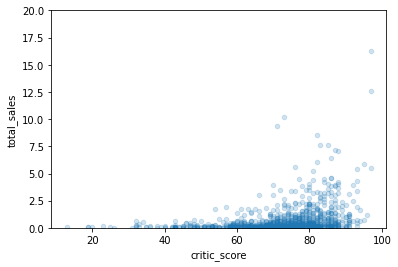

In [91]:
data_actual.plot(x='critic_score',y='total_sales',kind='scatter', alpha = 0.2)
plt.ylim(0,20)

There is a smoother relationship between critical ratings and overall sales - but as with user ratings, most sales are concentrated between 0 and 2.5M sales.

In [92]:
print('Correlation between critic scores and sales', data_actual['critic_score'].corr(data_actual['total_sales']))

Correlation between critic scores and sales 0.31341431941861386


The correlation is stronger. This may be due to the fact that before the release of the game, people have no option but to rely on reviews from critics.

In [93]:
display(data_actual[data_actual['critic_score']>90])

,name,platform,year_of_release,genre,critic_score,user_score,rating,rating_general,na_sales,eu_sales,jp_sales,other_sales,total_sales,platform_producer,leading_platform
1091,bayonetta 2,wiiu,2014,Action,91.0,8.2,M,M,0.32,0.28,0.10,0.06,0.76,nintendo,True
1244,bioshock infinite,pc,2013,Shooter,94.0,8.5,M,M,0.29,0.30,0.00,0.07,0.66,mixed,True
1245,bioshock infinite,ps3,2013,Shooter,94.0,8.5,M,M,0.72,0.65,0.04,0.28,1.69,sony,True
1246,bioshock infinite,x360,2013,Shooter,93.0,8.5,M,M,1.22,0.54,0.02,0.16,1.94,microsoft,True
1375,bloodborne,ps4,2015,Action,92.0,8.6,M,M,1.03,0.81,0.26,0.38,2.48,sony,True
2693,dark souls ii,pc,2014,Role-Playing,91.0,7.1,T,E10+,0.08,0.08,0.00,0.01,0.17,mixed,True
2694,dark souls ii,ps3,2014,Role-Playing,91.0,8.1,T,E10+,0.40,0.33,0.40,0.15,1.28,sony,True
2696,dark souls ii,x360,2014,Role-Playing,91.0,7.9,T,E10+,0.48,0.18,0.01,0.07,0.74,microsoft,True
4759,forza horizon 3,xone,2016,Racing,91.0,7.4,E,E,0.42,0.58,0.00,0.08,1.08,microsoft,True
5288,grand theft auto v,pc,2015,Action,96.0,7.9,M,M,0.39,0.69,0.00,0.09,1.17,mixed,True


We see a large number of highly rated clone games and sales are not stable. As stated earlier, there can be many reasons for this. But this does not depend on ratings, but, as we found out earlier, on the platform.

Subtotal:

Player and critic ratings do not greatly affect overall sales across all platforms.

Now let's look at the same data in the context of platforms.

#### User scores

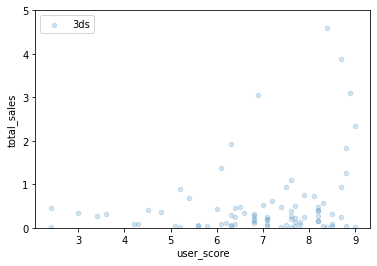

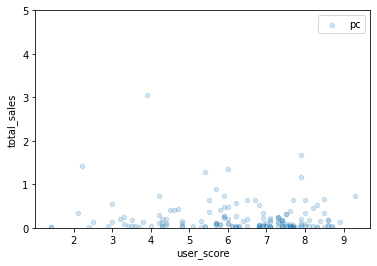

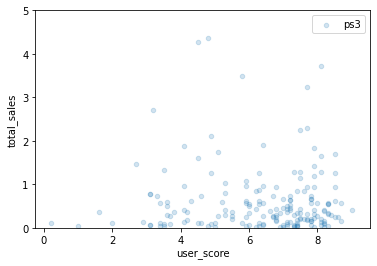

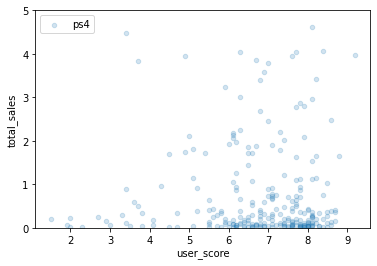

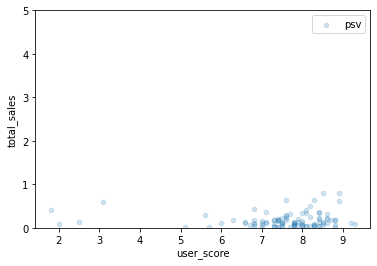

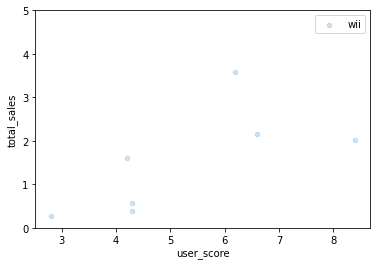

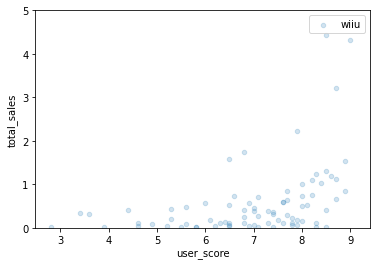

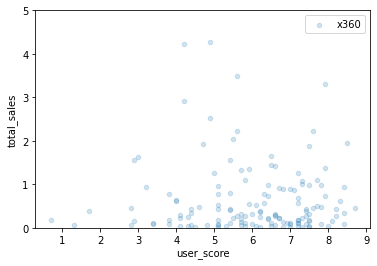

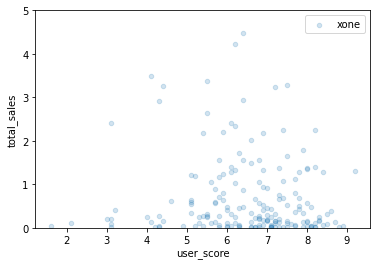

In [94]:
for row in leading_platforms:
    data_actual[data_actual['platform'] == row].plot(x='user_score',y='total_sales',kind='scatter', by ='platform', alpha = 0.2, label = row)
    plt.ylim(0,5)
    plt.show

In [95]:
for row in leading_platforms:
    print('Correlation between sales and user scores for', row, data_actual.loc[data_actual['platform'] == row, 'user_score'].corr(data_actual.loc[data_actual['platform'] == row, 'total_sales']).round(2))

Correlation between sales and user scores for 3ds 0.25
Correlation between sales and user scores for pc -0.09
Correlation between sales and user scores for ps3 0.0
Correlation between sales and user scores for ps4 -0.03
Correlation between sales and user scores for psv 0.0
Correlation between sales and user scores for wii 0.68
Correlation between sales and user scores for wiiu 0.42
Correlation between sales and user scores for x360 -0.01
Correlation between sales and user scores for xone -0.07


Our leading platform is from Nintendo. All three consoles rely heavily on user ratings for sales. And for other consoles, the correlation is sometimes even negative. You could say that the higher the scores, the better the sales, but that's the general logic. Trying to sell games with a rating of 1 from the players themselves will not be right.

#### Critic scores

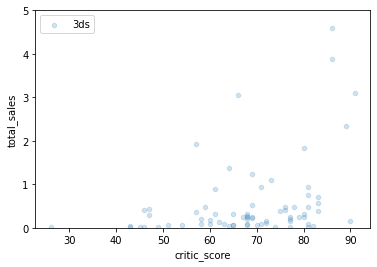

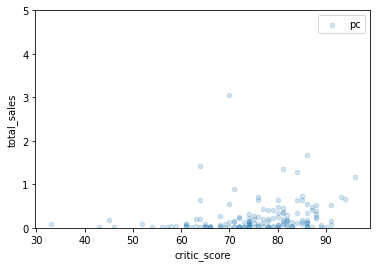

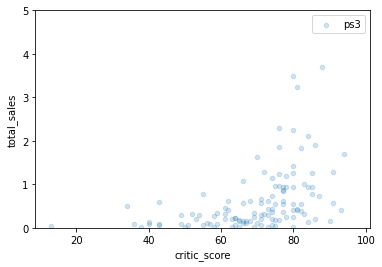

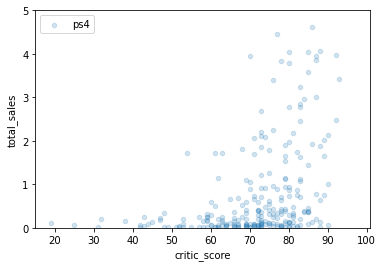

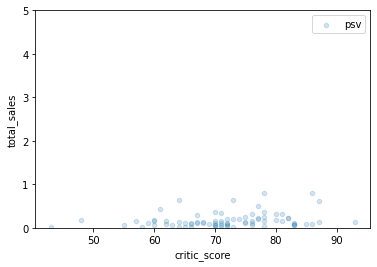

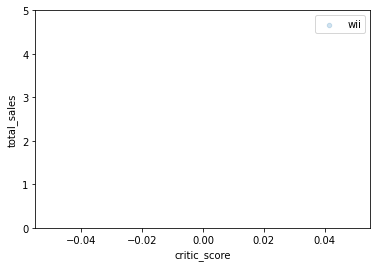

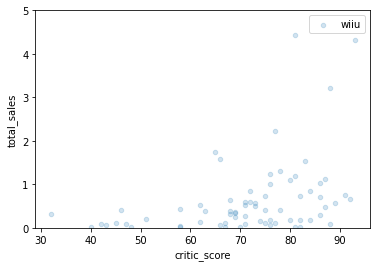

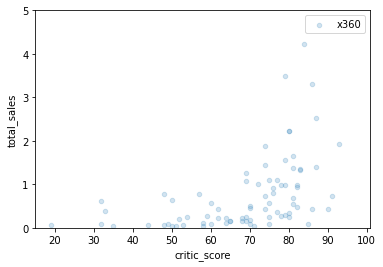

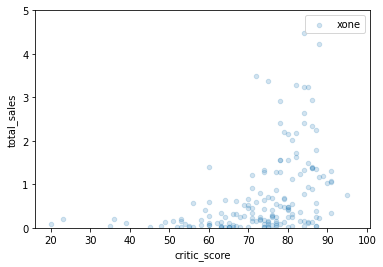

In [96]:
for row in leading_platforms:
    data_actual[data_actual['platform'] == row].plot(x='critic_score',y='total_sales',kind='scatter', by ='platform', alpha = 0.2, label = row)
    plt.ylim(0,5)
    plt.show

But in the case of critics' ratings, even on the graphs, a stronger dependence is visible, especially for the playstation and x360 platforms. As mentioned earlier, this may be because the critics' ratings come out before the users' ratings, and people buy a fresh game based on the critics' reviews. But it can also be for the following reason: not all players "sit" on the forums with ratings. Many choose to play based on the opinions of experts - people also act in many other things, like restaurants, hotels and so on.

In [97]:
for row in leading_platforms:
    print('Correlation between critic scores and sales for', row, data_actual.loc[data_actual['platform'] == row, 'critic_score'].corr(data_actual.loc[data_actual['platform'] == row, 'total_sales']))

Correlation between critic scores and sales for 3ds 0.36175210569969085
Correlation between critic scores and sales for pc 0.199659848363802
Correlation between critic scores and sales for ps3 0.3342853393371919
Correlation between critic scores and sales for ps4 0.40656790206178134
Correlation between critic scores and sales for psv 0.25769484783556745
Correlation between critic scores and sales for wii nan
Correlation between critic scores and sales for wiiu 0.37641490654239096
Correlation between critic scores and sales for x360 0.3503445460228664
Correlation between critic scores and sales for xone 0.41699832800840203


The platform correlation coefficients only confirm that critics' ratings are "more useful" for sales - the correlation is positive everywhere. Moreover, this applies to the top consoles - the playstation and xbox lines. there the correlation is above 40 points, and for them we can safely plan that the games highly acclaimed by critics will become, if not hits, then they will be in the top sales.

Subtotal:\
Critics' ratings affect sales more than user ratings. But you can't ignore user ratings - if a store has a return policy, players are more likely to bring the game back, and this will result in hidden losses.

### Genre and sales

Genres in games are the most difficult category. You might think that there is a recipe for success: do this with that, and there will be a hit. But sometimes completely unexpected games break out into the tops - puzzles, games about gardening or caring for puppies - and they are played by absolutely all categories of players. It is necessary not to forget that only the genre, or vice versa, the theme does not decide the success of the game. Left 4 dead and The last of us are both zombie games, but one is a team-based time survival game with sales, and the other is a legendary game about a post-apocalyptic foster father-daughter relationship, but both score high.\
Plus, as previously stated, marketing has an incredible impact on a game's popularity (and sales, but some online stores don't allow returns, so if we combined sold and returned games, the outcome could be different). It is said that marketing expenses on Left 4 Dead were around 25 million USD, while Last of Us spent almost 100 million USD.

In [98]:
print('Total sales The last of us', data.loc[data['name'] == 'the last of us', 'total_sales'].sum())
print('Total sales Left 4 dead', data.loc[data['name'] == 'left 4 dead', 'total_sales'].sum())

Total sales The last of us 10.58
Total sales Left 4 dead 3.52


#### General data

For this analysis, we use data after 2005, but using all platforms. Why we include all consoles - the wii specialty is the accessory devices. The wii was originally advertised as a "workout platform". A huge number of sports interactive games, yoga, warm-up and so on have been released on it. So by removing it from selection we might get partial view of the situation.

In [99]:
genre_grouping = data[data['year_of_release'] > 2005].groupby(['genre', 'platform']).agg({'total_sales':['sum','count']})
genre_grouping.columns = ['total_sales', 'number_of_games']
genre_grouping = genre_grouping.sort_values(by = 'total_sales', ascending = False)
print(genre_grouping.reset_index().groupby('genre')['total_sales'].sum().sort_values(ascending = False))

genre
Action          1136.09
Sports           799.80
Shooter          722.65
Misc             565.73
Role-Playing     523.38
Racing           300.56
Platform         280.30
Simulation       222.27
Fighting         188.68
Adventure        141.71
Puzzle            90.63
Strategy          74.66
Name: total_sales, dtype: float64


According to the table above, the three most popular genres are shooter, action and sports. Popularity, again, does not mean that any game released will be a hit. In addition to this, you need to check which specific platforms the most popular genres were on.

In [100]:
display(genre_grouping.head(10))

total_sales  number_of_games
genre        platform                              
Action       ps3            301.59              380
Sports       wii            288.54              260
Shooter      x360           273.48              199
Action       x360           238.40              318
Misc         wii            216.21              280
Shooter      ps3            192.54              156
Sports       x360           136.44              210
             ps3            133.78              212
Role-Playing ds             120.50              191
Action       wii            114.46              237

It turned out that action, although the most profitable, but also the most prolific genre - it is corny the most games. Let's find out on which platforms the average "sales per game" in the top.

In [101]:
genre_grouping['sales_per_game'] = genre_grouping['total_sales'] / genre_grouping['number_of_games']
display(genre_grouping.sort_values(by = 'sales_per_game', ascending = False).head(10))

total_sales  number_of_games  sales_per_game
genre    platform                                              
Racing   wiiu             7.87                3        2.623333
Shooter  ps4             88.56               41        2.160000
         xone            60.33               38        1.587632
Platform wii             88.92               58        1.533103
Shooter  x360           273.48              199        1.374271
Racing   3ds             14.96               11        1.360000
Platform wiiu            21.53               17        1.266471
Fighting wiiu             6.27                5        1.254000
Shooter  ps3            192.54              156        1.234231
Sports   ps4             55.61               46        1.208913

When we deduced sales for one game, the racing genre got into the top - although earlier action was in the top. Moreover, the shooter genre appeared in second place. In third place is the platform genre. In general, the situation of profitability per game is diametrically opposed to the overall sales in the genre by platform. We cannot yet say for sure which genre is the most golden. It is necessary to check the least profitable genres, as well as the genres among the actual data - the leading consoles and in a certain period of time.

According to one of the tables above, the adventure, puzzle, and strategy genres bring in the least money. Let's check by platform, as well as by profitability per game.

In [102]:
 display(genre_grouping.sort_values(by = 'total_sales').head(10))

,,total_sales,number_of_games,sales_per_game
genre,platform,,,
Shooter,dc,0.02,1,0.02
Puzzle,ps4,0.02,1,0.02
Shooter,gba,0.03,1,0.03
Misc,xb,0.03,1,0.03
Adventure,dc,0.04,1,0.04
Strategy,xb,0.04,1,0.04
Adventure,xb,0.04,1,0.04
Simulation,psv,0.08,4,0.02
Puzzle,gba,0.08,2,0.04


In the least profitable games in terms of sales, we see both a top shooter and a low puzzle - but a lot of unpopular platforms. It is necessary to proceed to the analysis according to the actual data.

#### Actual data

Let's apply the same grouping method as above, but based on actual data.

In [103]:
genre_grouping_actual = data_actual.groupby(['genre', 'platform']).agg({'total_sales':['sum','count']})
genre_grouping_actual.columns = ['total_sales', 'number_of_games']
genre_grouping_actual = genre_grouping_actual.sort_values(by = 'total_sales', ascending = False)
genre_grouping_actual['sales_per_game'] = genre_grouping_actual['total_sales'] / genre_grouping_actual['number_of_games']

In [104]:
display(genre_grouping_actual.reset_index().groupby('genre')['total_sales'].sum().sort_values(ascending = False))

genre
Action          321.14
Shooter         233.05
Sports          149.93
Role-Playing    145.15
Misc             62.57
Platform         41.94
Racing           39.98
Fighting         35.29
Adventure        22.99
Simulation       21.74
Strategy         10.06
Puzzle            3.17
Name: total_sales, dtype: float64

We see a slightly different breakdown of the top 3 genres. Now shooter takes 2nd place, and sports moved to 3rd place. But all previous top and low genres have kept their positions.

In [105]:
display(genre_grouping_actual.head(10))

total_sales  number_of_games  sales_per_game
genre        platform                                              
Action       ps4             96.10              144        0.667361
Shooter      ps4             88.56               41        2.160000
Action       ps3             70.92              114        0.622105
Role-Playing 3ds             67.40               63        1.069841
Shooter      xone            60.33               38        1.587632
Sports       ps4             55.61               46        1.208913
Action       x360            47.59               62        0.767581
             xone            37.31               85        0.438941
Shooter      x360            35.48               34        1.043529
Action       3ds             34.04              116        0.293448

Based on the overall sales data, we can state the following:
1) Genre Action : popular for absolutely all platforms, both old and new generation.\
2) Genre Sports: especially popular on the wii platform, as mentioned earlier (this is her specialty). We can also assume that for the wiiu this genre will become top. But for x360 and ps3, these genres are popular, although they have a completely\
3) Shooter genre: available for x360 and ps3, but there are no games for new generations of these consoles yet - you need to be careful with this genre. For this genre, you need to check the progression by year.\
4) Role-Playing Genre: dark horse, but also popular only on the wii platform. Lets think that for the next generation of this console we will see the popularity of this genre.

But we are not only looking for the most popular, but also the most profitable genres. Let's check the profitability of the game. different principle for creating such games.\

In [106]:
display(genre_grouping_actual[genre_grouping_actual['sales_per_game'] > 0.9].sort_values(by = 'sales_per_game', ascending = False))

total_sales  number_of_games  sales_per_game
genre        platform                                              
Racing       wiiu             7.36                2        3.680000
Shooter      ps4             88.56               41        2.160000
             xone            60.33               38        1.587632
Fighting     wiiu             6.09                4        1.522500
Misc         x360            12.49                9        1.387778
Sports       ps4             55.61               46        1.208913
Fighting     3ds              8.21                7        1.172857
Platform     wii              2.25                2        1.125000
             wiiu            16.27               15        1.084667
Role-Playing 3ds             67.40               63        1.069841
Shooter      x360            35.48               34        1.043529
             ps3             31.79               31        1.025484
Misc         wii              7.06                7        1.008571

Here we see a slightly different picture - in addition to the Action, Shooter and Sports genres, we see the following genres:
1) Racing : only platforms from nintendo got into the top.\
2) Fighting: one might say, a unique genre for the nintendo manufacturer (wii and 3ds platforms). These are Mario games and so on.\
3) Role-Playing: for 3ds, that is, there seems to be a platform dependency.

Let's quickly check unpopular genres.

In [107]:
display(genre_grouping_actual.sort_values(by = 'sales_per_game').head(10))

total_sales  number_of_games  sales_per_game
genre      platform                                              
Simulation psv              0.05                3        0.016667
Puzzle     ps4              0.02                1        0.020000
           psv              0.06                2        0.030000
Racing     psv              0.10                3        0.033333
Platform   pc               0.07                2        0.035000
Puzzle     ps3              0.04                1        0.040000
Adventure  psv              3.45               86        0.040116
           pc               0.51               11        0.046364
Strategy   psv              0.35                7        0.050000
Fighting   pc               0.10                2        0.050000

In [108]:
display(genre_grouping_actual.sort_values(by = 'total_sales').head(10))

total_sales  number_of_games  sales_per_game
genre      platform                                              
Puzzle     ps4              0.02                1        0.020000
           ps3              0.04                1        0.040000
Simulation psv              0.05                3        0.016667
Puzzle     psv              0.06                2        0.030000
Platform   pc               0.07                2        0.035000
Racing     3ds              0.09                1        0.090000
Fighting   pc               0.10                2        0.050000
Racing     psv              0.10                3        0.033333
Shooter    3ds              0.13                2        0.065000
Simulation wii              0.14                1        0.140000

Browsing by total sales and profitability by game yields pretty much the same set of genres. They can say the following:

Puzzle : On all playstation platforms, puzzles are the most unpopular games.

The rest of the genres on the list - you can't say for sure that they won't be popular - but you have to take into account the platforms where these genres don't sell very well.

Subtotal:

Profitable : in addition to Action(all platforms), Sports(all platforms), Shooter(stationary xbox and playstation) we can say that the racing and platform genres for consoles from nintendo can additionally be considered as potential leaders.

Not Profitable: Definitely a puzzle for Sony's consoles. The rest depend heavily on additional factors.

In [109]:
top_genres = [['Action',['3ds', 'pc', 'ps3', 'ps4', 'psv', 'wii', 'wiiu', 'x360', 'xone']],
             ['Sports',['3ds', 'pc', 'ps3', 'ps4', 'psv', 'wii', 'wiiu', 'x360', 'xone']],
             ['Shooter',['ps3', 'ps4', 'x360', 'xone']],
             ['Racing',['3ds','wii', 'wiiu']],
             ['Role-Playing',['3ds']]]

In [110]:
bottom_genres = [['Puzzle', ['ps3', 'ps4', 'psv']],
                ['Adventure', ['3ds', 'pc', 'ps3', 'ps4', 'psv', 'wii', 'wiiu', 'x360', 'xone']], 
                ['Other']]

## User analysis

We will compile a portrait of users in each region according to the following factors: genre + platform (and, accordingly, manufacturer) + platform type, as well as the assessment of critics and users. For this analysis, we need to use exclusively up-to-date data.

In [111]:
eu_users = data_trends[data_trends['eu_sales'] > 0].drop(columns=['jp_sales', 'na_sales', 'other_sales'])
eu_users['region'] = 'eu'
eu_users.rename(columns={'eu_sales': 'region_sales'}, inplace=True)

jp_users = data_trends[data_trends['jp_sales'] > 0].drop(columns=['eu_sales', 'na_sales', 'other_sales'])
jp_users['region'] = 'jp'
jp_users.rename(columns={'jp_sales': 'region_sales'}, inplace=True)

na_users = data_trends[data_trends['na_sales'] > 0].drop(columns=['jp_sales', 'eu_sales', 'other_sales'])
na_users['region'] = 'na'
na_users.rename(columns={'na_sales': 'region_sales'}, inplace=True)

### Europe

<AxesSubplot:title={'center':'Actual period 2012-2016'}, xlabel='platform'>

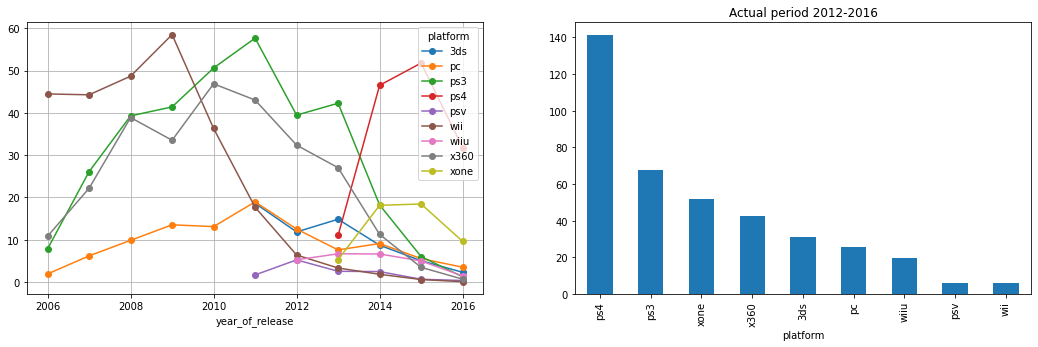

In [112]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

eu_users.pivot_table(index='year_of_release', columns = 'platform', values = 'region_sales', aggfunc = 'sum').plot(ax = axes[0], style='o-', grid=True)
eu_users[eu_users['year_of_release'] > 2012].groupby('platform')['region_sales'].sum().sort_values(ascending = False).plot(ax = axes[1],kind = 'bar', title = 'Actual period 2012-2016')

The most popular platform is playstation 4. The overall top 5 platforms in recent years are ps3, xone, 3ds, ps4 and pc. Over the entire period, the most popular platform was the ps4, and as an xone it is already superior to its predecessor.\
The xone didn't reach annual x360 sales, but like the wiiu, it has potential based on the sales of its predecessors.

<AxesSubplot:title={'center':'Actual period 2012-2016'}, xlabel='genre'>

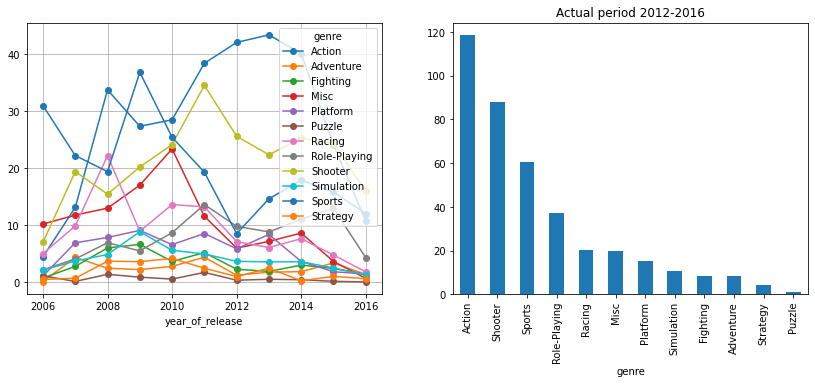

In [113]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

eu_users.pivot_table(index='year_of_release', columns = 'genre', values = 'region_sales', aggfunc = 'sum').plot(ax = axes[0], style='o-', grid=True, figsize=(14, 5))
eu_users[eu_users['year_of_release'] > 2012].groupby('genre')['region_sales'].sum().sort_values(ascending = False).plot(ax = axes[1],kind = 'bar', title = 'Actual period 2012-2016')

In [114]:
display(eu_users.groupby(['platform', 'genre'])['region_sales'].sum().sort_values(ascending = False).head(10))

platform  genre  
ps3       Action     105.95
wii       Sports      93.78
x360      Shooter     74.49
          Action      73.54
ps3       Shooter     72.64
wii       Misc        63.93
ps3       Sports      46.64
ps4       Action      42.71
          Shooter     39.16
x360      Sports      36.30
Name: region_sales, dtype: float64

In the case of genres, the situation is as follows: in 2015 - 2016, the most popular genres were action, shooter, sports, role-playing and racing. The same breakdown and in terms of the overall breakdown of sales, the situation is slightly different. The distribution of popular genres is identical to the general distribution found earlier.

In [115]:
display(top_genres)

[['Action', ['3ds', 'pc', 'ps3', 'ps4', 'psv', 'wii', 'wiiu', 'x360', 'xone']],
 ['Sports', ['3ds', 'pc', 'ps3', 'ps4', 'psv', 'wii', 'wiiu', 'x360', 'xone']],
 ['Shooter', ['ps3', 'ps4', 'x360', 'xone']],
 ['Racing', ['3ds', 'wii', 'wiiu']],
 ['Role-Playing', ['3ds']]]

<AxesSubplot:xlabel='user_score', ylabel='region_sales'>

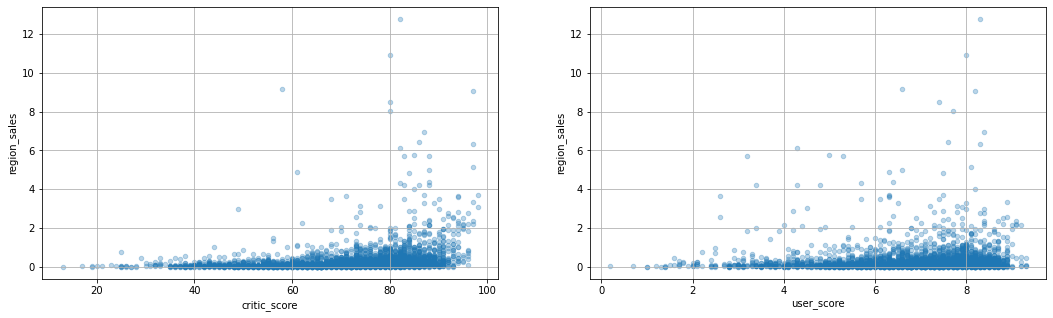

In [116]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

eu_users[eu_users['region_sales'] < 15].plot(ax = axes[0], x = 'critic_score', y = 'region_sales', kind='scatter', grid=True, alpha = 0.3)
eu_users[eu_users['region_sales'] < 15].plot(ax = axes[1], x = 'user_score', y = 'region_sales', kind='scatter', grid=True, alpha = 0.3)

In [117]:
print('Correlation between critic score and sales',eu_users['critic_score'].corr(eu_users['region_sales']).round(2))
print('Correlation between user score and sales',eu_users['user_score'].corr(eu_users['region_sales']).round(2))

Correlation between critic score and sales 0.23
Correlation between user score and sales 0.06


The relationship between critic or player ratings and sales remains. As has been found for overall sales, critic ratings influence sales more than user ratings.

<AxesSubplot:title={'center':'Number of games per rating'}, xlabel='year_of_release'>

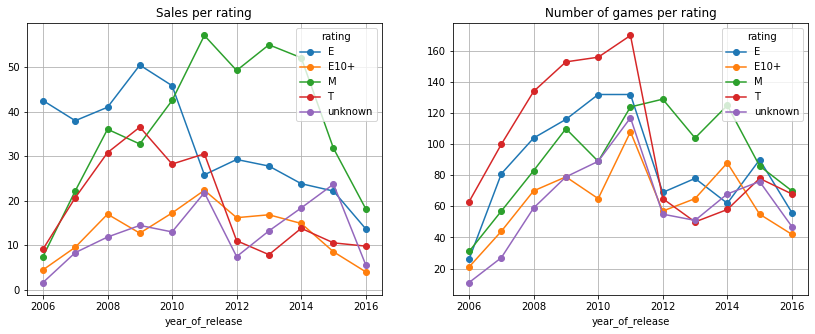

In [118]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

eu_users.pivot_table(index='year_of_release', columns = 'rating', values = 'region_sales', aggfunc = 'sum').plot(ax = axes[0],style='o-', grid=True, figsize=(14, 5), title = 'Sales per rating')
eu_users.pivot_table(index='year_of_release', columns = 'rating', values = 'region_sales', aggfunc = 'count').plot(ax = axes[1],style='o-', grid=True, figsize=(14, 5), title ='Number of games per rating')

Games with an M rating sell best. At the same time, the number of games has also changed - the dependence is direct. Starting to release more M-rated games and fewer other-rated games. This is probably due to the fact that M-rated games can be bought by near-adults who have played the games before - you can see that around 2010, E-rated games clashed with M-rated games and went down. In other words, the composition of the players has changed. This may also be due to the fact that games have become possible to buy online, and on the Internet it is easier to fake the age when buying.\
But do not forget that the ESRB rating is an American rating, and in Europe there may be other age limits.

Subtotal:
    
Typical game buyer in the European region:
- most likely over 17 years old. Even if you do not pay attention to age, he will be more willing to buy games with an M and E rating.
- pays more attention to the ratings of critics than other players, but this does not greatly affect his purchasing power
- For at least the next 5 years, he will happily buy games for the following platforms: ps4, xone, wiiu and their predecessors, as well as pc
- On these platforms, he will prioritize the following genres: action, shooter, sports (the consumer will be particularly inclined to buy games of this genre on the wii platform), role-playing and racing.

### North America

<AxesSubplot:title={'center':'Actual period 2012-2016'}, xlabel='platform'>

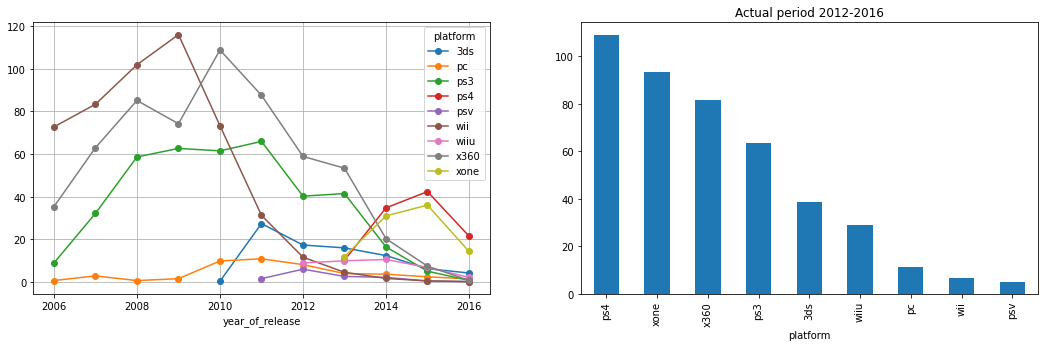

In [119]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

na_users.pivot_table(index='year_of_release', columns = 'platform', values = 'region_sales', aggfunc = 'sum').plot(ax = axes[0], style='o-', grid=True)
na_users[na_users['year_of_release'] > 2012].groupby('platform')['region_sales'].sum().sort_values(ascending = False).plot(ax = axes[1],kind = 'bar', title = 'Actual period 2012-2016')

Americans are more fond of games on microsoft platforms - which is logical, because microsoft has more opportunities for advertising and other things in their native country. At the same time, if the total sales between x360 and ps3 vary greatly, there is no such strong difference between their descendants - for the last three years they have been going head-to-head. But in the 2010s, wii had absolute popularity, followed by a sharp drop.\
Therefore, although the top 5 platforms include x360, wii, ps3, ps4 and xone, it can be said that the most potentially profitable is likely to be xone as the x360 successor.

<AxesSubplot:xlabel='genre'>

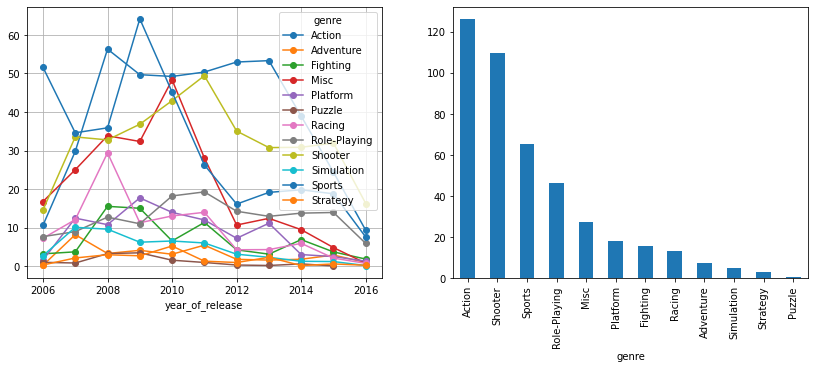

In [120]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(25,5))

na_users.pivot_table(index='year_of_release', columns = 'genre', values = 'region_sales', aggfunc = 'sum').plot(ax = axes[0], style='o-', grid=True, figsize=(14, 5))
na_users[na_users['year_of_release'] > 2012].groupby('genre')['region_sales'].sum().sort_values(ascending = False).plot(ax = axes[1],kind = 'bar')

In [121]:
display(na_users.groupby(['platform', 'genre'])['region_sales'].sum().sort_values(ascending = False).head(10))

platform  genre  
x360      Shooter    171.47
wii       Sports     149.72
x360      Action     140.61
ps3       Action     121.47
wii       Misc       118.82
x360      Sports      88.32
ps3       Shooter     82.03
wii       Action      68.07
x360      Misc        63.66
ps3       Sports      60.91
Name: region_sales, dtype: float64

But in terms of the popularity of genres, the tastes of the American audience do not differ from the European ones - in the absolute top, the same action, shooter, sports and role-playing are again. The top in total sales also contains misc - this is for a platform that has lost its popularity - wii.

<AxesSubplot:xlabel='user_score', ylabel='region_sales'>

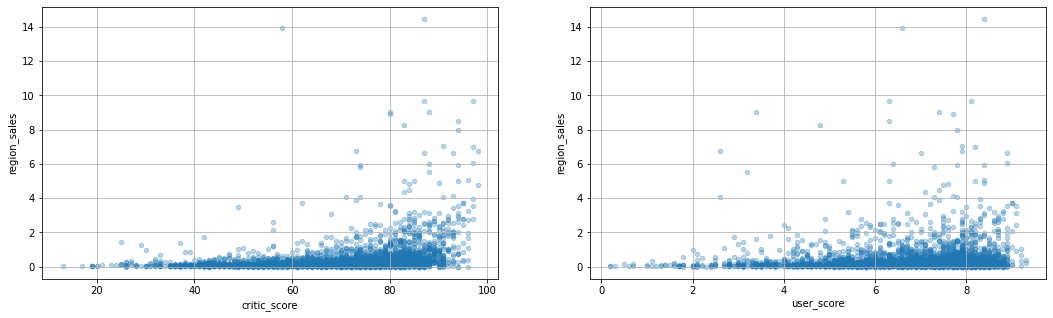

In [122]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

na_users[na_users['region_sales'] < 15].plot(ax = axes[0], x = 'critic_score', y = 'region_sales', kind='scatter', grid=True, alpha = 0.3)
na_users[na_users['region_sales'] < 15].plot(ax = axes[1], x = 'user_score', y = 'region_sales', kind='scatter', grid=True, alpha = 0.3)

In [123]:
print('Correlation between critic score and sales',na_users['critic_score'].corr(na_users['region_sales']).round(2))
print('Correlation between user score and sales',na_users['user_score'].corr(na_users['region_sales']).round(2))

Correlation between critic score and sales 0.24
Correlation between user score and sales 0.09


The correlation between scores does not differ from all previous results. Critics' ratings affect sales a little more than user ratings, but still not as much.

<AxesSubplot:title={'center':'Number of games per rating'}, xlabel='year_of_release'>

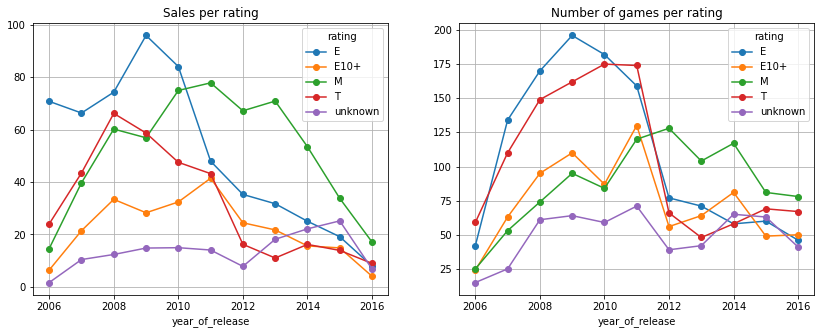

In [124]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

na_users.pivot_table(index='year_of_release', columns = 'rating', values = 'region_sales', aggfunc = 'sum').plot(ax = axes[0],style='o-', grid=True, figsize=(14, 5), title = 'Sales per rating')
na_users.pivot_table(index='year_of_release', columns = 'rating', values = 'region_sales', aggfunc = 'count').plot(ax = axes[1],style='o-', grid=True, figsize=(14, 5), title ='Number of games per rating')

It seems that in terms of ratings, the statistics of sales levels do not differ much from European ones, except for the number of released games - they are slightly less than in Europe. But even here, more M-rated games began to be released, while the T and E ratings almost equaled in terms of sales, and the dependence on the number of released games is inverse. In Europe, E is more popular.

Subtotal:
    
Typical game buyer in the Americas:
- most likely over 14 years old. Even if age is not taken into account, he will be more willing to buy M and T rated games.
- pays more attention to the ratings of critics than other players, but this does not greatly affect his purchasing power
- For at least the next 5 years, he will be happy to buy games on the following platforms: xone and x360, less willingly ps3 and ps4.
- On these platforms, he will prioritize the following genres: action, shooter, sports (the consumer will be particularly inclined to buy games of this genre on the wii platform), role-playing and racing.

### Japan

<AxesSubplot:title={'center':'Actual period 2012-2016'}, xlabel='platform'>

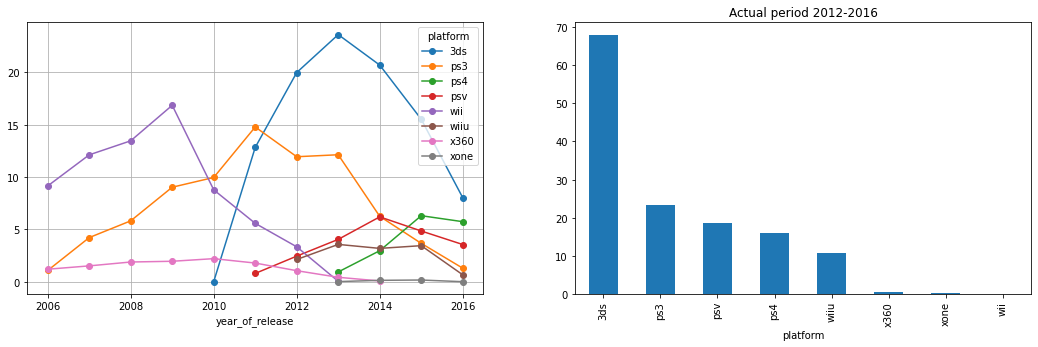

In [125]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

jp_users.pivot_table(index='year_of_release', columns = 'platform', values = 'region_sales', aggfunc = 'sum').plot(ax = axes[0], style='o-', grid=True)
jp_users[jp_users['year_of_release'] > 2012].groupby('platform')['region_sales'].sum().sort_values(ascending = False).plot(ax = axes[1],kind = 'bar', title = 'Actual period 2012-2016')

As expected, the Japanese consumer has diametrically opposed preferences. He buys more games for the so-called portable consoles - 3ds, psv. In principle, in the top consoles from Japanese manufacturers - sony, nintendo. Platforms from microsoft in Japan are in the absolute minority.

<AxesSubplot:title={'center':'Actual period 2012-2016'}, xlabel='genre'>

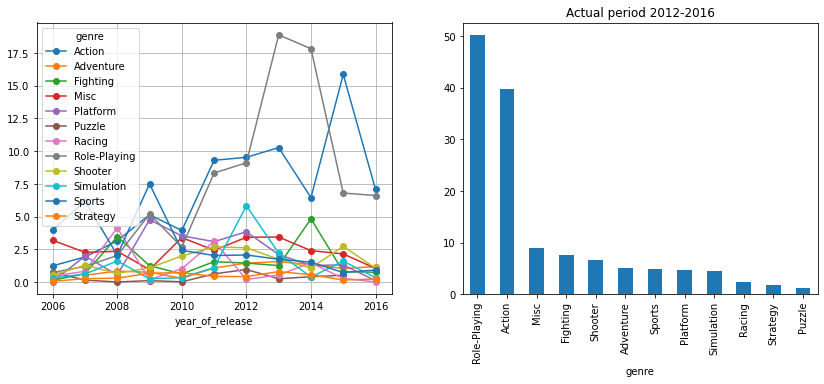

In [126]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(25,5))

jp_users.pivot_table(index='year_of_release', columns = 'genre', values = 'region_sales', aggfunc = 'sum').plot(ax = axes[0], style='o-', grid=True, figsize=(14, 5))
jp_users[jp_users['year_of_release'] > 2012].groupby('genre')['region_sales'].sum().sort_values(ascending = False).plot(ax = axes[1],kind = 'bar', title = 'Actual period 2012-2016')

In [127]:
display(jp_users.groupby(['platform', 'genre'])['region_sales'].sum().sort_values(ascending = False).head(10))

platform  genre       
3ds       Role-Playing    41.99
ps3       Action          29.65
3ds       Action          22.66
wii       Sports          18.25
ps3       Role-Playing    16.85
wii       Misc            14.48
          Platform        11.24
3ds       Simulation      10.39
ps3       Shooter          8.81
          Sports           7.96
Name: region_sales, dtype: float64

A different picture is also observed in genres. The Japanese are more into role-playing, action games, but shooter, fighting, and adventure genres have also become popular lately.

<AxesSubplot:xlabel='user_score', ylabel='region_sales'>

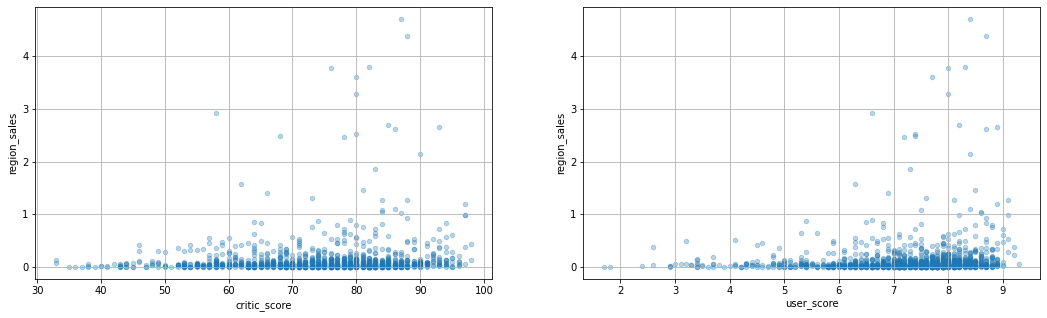

In [128]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

jp_users[jp_users['region_sales'] < 15].plot(ax = axes[0], x = 'critic_score', y = 'region_sales', kind='scatter', grid=True, alpha = 0.3)
jp_users[jp_users['region_sales'] < 15].plot(ax = axes[1], x = 'user_score', y = 'region_sales', kind='scatter', grid=True, alpha = 0.3)

In [129]:
print('Correlation between critic score and sales',jp_users['critic_score'].corr(jp_users['region_sales']).round(2))
print('Correlation between user score and sales',jp_users['user_score'].corr(jp_users['region_sales']).round(2))

Correlation between critic score and sales 0.11
Correlation between user score and sales 0.12


A separate feature of the assessments in the Japanese region is that they do not give assessments with decimal parts. And the correlation between ratings and sales is non-standard - in general, ratings have little to no effect on how a game will sell. This may indicate a completely different method of selecting games to buy.

<AxesSubplot:title={'center':'Number of games per rating'}, xlabel='year_of_release'>

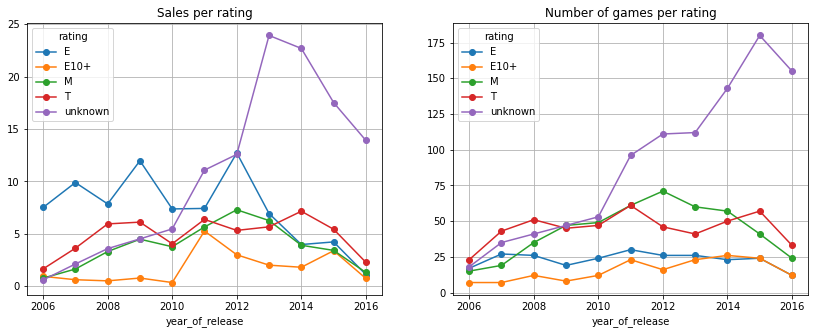

In [130]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,5))

jp_users.pivot_table(index='year_of_release', columns = 'rating', values = 'region_sales', aggfunc = 'sum').plot(ax = axes[0],style='o-', grid=True, figsize=(14, 5), title = 'Sales per rating')
jp_users.pivot_table(index='year_of_release', columns = 'rating', values = 'region_sales', aggfunc = 'count').plot(ax = axes[1],style='o-', grid=True, figsize=(14, 5), title ='Number of games per rating')

And sales according to ESRB ratings also differ - earlier in Japan, in the absolute majority, E-rated games were best sold for a long time, and there were almost the least of them - only E10+ was lower both in sales and in the number of games. But in recent years, T-rated games have become more actively sold and released. But M-rated games, popular in America and Europe, although they are produced in huge quantities, in fact they bring much less money than expected.

Subtotal:
    
Typical game buyer in the Japan region:
- age is difficult to determine. In principle, the Japanese nation is less critical of computer players, and there are many categories of different ages. Even aside from age, Japanese users are more likely to buy T and E rated games.
- practically does not pay attention to the assessments of critics or players.
- For at least the next 5 years, he will be happy to buy games on the following platforms: the 3ds portable platform and its potential descendant, as well as any platforms from nintendo and sony, that is, taking into account the life cycle of the ps4 and wiiu platform.
- On these platforms, he will prioritize the following genres: the role-playing and action genres will be the absolute winners, but also the shooter, sport and platform genres can be on the shopping list.

# Statistical analysis

## Theory: The average user ratings of the Xbox One and PC platforms are the same

Null Hypothesis: The average user ratings of the Xbox One and PC platforms are the same, i.e. users rate both the Xbox One platform and the PC platform equally.

Alternative hypothesis: The average user ratings of the Xbox One and PC platforms are different, that is, users rate these platforms differently.

In [131]:
alpha = 0.05

xone_user_score = data_actual.loc[data_actual['platform'] == 'xone', 'user_score'].dropna()
pc_user_score = data_actual.loc[data_actual['platform'] == 'pc', 'user_score'].dropna()

results = st.ttest_ind(
    xone_user_score, 
    pc_user_score)
# testing the hypothesis that the means of two independent populations are equal

print('p-value:', results.pvalue)

if results.pvalue < alpha: # comparing the resulting p-value with a given level of statistical significance:
    print("Rejecting the null hypothesis")
else:
    print("Not rejecting the null hypothesis")

p-value: 0.15503167687396294
Not rejecting the null hypothesis


The null hypothesis is rejected - the average ratings of the platforms are not the same. This means that users like one of the platforms more.

## Theory: Average user ratings for Action and Sports genres are different

Null Hypothesis: The average user ratings of the Action and Sports genres are different, i.e. users like both genres equally.

Alternative hypothesis: The average user ratings of the Action and Sports genres are different, i.e. users prefer one genre more.

In [132]:
alpha = 0.05

action_user_score = data_actual.loc[data_actual['genre'] == 'Action', 'user_score'].dropna()
sports_user_score = data_actual.loc[data_actual['genre'] == 'Sports', 'user_score'].dropna()

results = st.ttest_ind(
    action_user_score, 
    sports_user_score)
# testing the hypothesis that the means of two independent populations are not equal

print('p-value:', results.pvalue)

if results.pvalue < alpha: # comparing the resulting p-value with a given level of statistical significance:
    print("Rejecting the null hypothesis")
else:
    print("Not rejecting the null hypothesis")

p-value: 1.4579650152603575e-27
Rejecting the null hypothesis


The null hypothesis is rejected - the average ratings among the two genres are different. This means that users prefer one of the genres more than the other.

# Finalisation of analysis

We needed to identify the patterns that determine the success of the game. This will allow you to bid on a potentially popular product and plan advertising campaigns.

First, we formulate the conditions for potential profitability for a user from an unknown region.

**Region not known.**

**1. Platform.**

In [133]:
print(leading_platforms)
print('Average life of platform -', lifetime , 'years')

['3ds' 'pc' 'ps3' 'ps4' 'psv' 'wii' 'wiiu' 'x360' 'xone']
Average life of platform - 10 years


Above we see which platforms have been popular since about 2005. Many of them are old generation consoles. This means that they already have successors, and theoretically console support will end soon. This does not mean the complete end of the release of games on these consoles, but sales on them will definitely decline. Such successor consoles, which we should pay attention to and consider potentially profitable in the next at least 5 years, are:
- xone - Microsoft's Xbox One, the successor to the Xbox 360. A stationary console, that is, it cannot be played on the go.
- ps4 - Play Station 4 from Sony, successor to Playstation 3. Stationary console, direct competitor to X One.
- 3ds - from Nintendo. Portable console. There is no heir yet - but as soon as he appears, it will be possible to focus on him in advertising.
- wiiu - from Nintendo, successor to the Wii. Stationary console with a large number of additional elements.

In principle, if the game was released for the old generation of the console, then it can be advertised immediately and advertised for the new generation, but not vice versa - games on new consoles are very often more demanding, and old versions may simply not pull them. Manufacturers may also simply not make compatibility with older versions of the console.
 ____________________________________________________________________________________________
The pc platform - it can be considered safe in the sense that everyone has computers, and it is on the pc that there are many options for the same games as on the console.
__________________
But the psv console will soon cease to exist - its sales are small, and it has not even reached the end of its life.

**2. Genre.**

In [134]:
display(top_genres)

[['Action', ['3ds', 'pc', 'ps3', 'ps4', 'psv', 'wii', 'wiiu', 'x360', 'xone']],
 ['Sports', ['3ds', 'pc', 'ps3', 'ps4', 'psv', 'wii', 'wiiu', 'x360', 'xone']],
 ['Shooter', ['ps3', 'ps4', 'x360', 'xone']],
 ['Racing', ['3ds', 'wii', 'wiiu']],
 ['Role-Playing', ['3ds']]]

In [135]:
display(bottom_genres)

[['Puzzle', ['ps3', 'ps4', 'psv']],
 ['Adventure',
  ['3ds', 'pc', 'ps3', 'ps4', 'psv', 'wii', 'wiiu', 'x360', 'xone']],
 ['Other']]

In terms of genres, everything is much easier. Above is a breakdown of the most popular and least popular genres by potentially profitable platform.

If the genre of the game for certain platforms is one of the following five:
- Action - any platforms
- Sports - any platform
- Shooter - stationary platforms from Microsoft and Sony
- Racing - all platforms from Nintendo
- Platform - all platforms from Nintendo

then this game can be advertised - of course, considering what kind of platform - it should be from the list of the most profitable platforms above.

But if the game has the Puzzle genre (especially for Sony platforms) or Adventure, then you need to be more careful with its advertising. In this case, you will most likely have to apply another method for assessing potential profitability - the assessment of critics and users.

**3. Scores.**

In [136]:
for row in leading_platforms:
    print('Correlation between critic score and sales', row, data_actual.loc[data_actual['platform'] == row, 'critic_score'].corr(data_actual.loc[data_actual['platform'] == row, 'total_sales']))

Correlation between critic score and sales 3ds 0.36175210569969085
Correlation between critic score and sales pc 0.199659848363802
Correlation between critic score and sales ps3 0.3342853393371919
Correlation between critic score and sales ps4 0.40656790206178134
Correlation between critic score and sales psv 0.25769484783556745
Correlation between critic score and sales wii nan
Correlation between critic score and sales wiiu 0.37641490654239096
Correlation between critic score and sales x360 0.3503445460228664
Correlation between critic score and sales xone 0.41699832800840203


In [137]:
for row in leading_platforms:
    print('Correlation between user score and sales', row, data_actual.loc[data_actual['platform'] == row, 'user_score'].corr(data_actual.loc[data_actual['platform'] == row, 'total_sales']).round(2))

Correlation between user score and sales 3ds 0.25
Correlation between user score and sales pc -0.09
Correlation between user score and sales ps3 0.0
Correlation between user score and sales ps4 -0.03
Correlation between user score and sales psv 0.0
Correlation between user score and sales wii 0.68
Correlation between user score and sales wiiu 0.42
Correlation between user score and sales x360 -0.01
Correlation between user score and sales xone -0.07


In general, we can rely more on critics' ratings as an influence on the popularity of the game than on feedback from players.\
Reviews come out earlier than user ratings, sometimes before the release of the game, sometimes right after the release. At the same time, critics could already go through the entire game, since they are given early access. The disadvantage of the critics' rating may be that if the game is difficult, and the critic is not an avid player, the rating may be lowered due to the fact that the critic simply could not progress through the game. Player ratings can be more accurate, but are highly subjective.

**4. ESRB Rating**

Age ratings are not the best way to gauge the popularity of a game. On the one hand, the potential audience of games decreases with an increase in the age limit, on the other hand, these people will definitely be able to buy the game, since their purchasing power is higher. This age rating was invented to control marketing, for parents and, in principle, for state regulators - somewhere, for example, games 18+ should be closed in special cases.

But not all games for adults are good, just like games for children. An E rating could mean playing a cartoon like Peppa. Adults will definitely not be able to play it, and it will be bought for 1+ players. Specific games like Manhunt will also not appeal to absolutely all adults.

There are games for everyone, like sports or team games, but they cannot be determined solely by rating.

Therefore, when determining the potential of a game for an unknown region, it is better not to use the ESRB rating.

**Region is known.**

Above, we have already found out typical buyers by region. These types can be directly projected into what games are better to advertise.

Potentially profitable game in the Americas:
- ESRB M and T rating.
- With average and high ratings from critics
- For platforms: xone and x360, ps3 and ps4 little worse.
- Genres on popular platforms: action, shooter, sports (the consumer will be especially inclined to buy games of this genre on the wii platform), role-playing and racing.
  
Potentially profitable game in the Japanese region:
- ESRB T and E rating.
- Ratings from critics and users equally affect sales.
- Platforms: 3ds and its potential descendant, as well as any platforms from nintendo and sony (taking into account the life cycle of the ps4 and wiiu platform).
- Genres: role-playing and action will be the absolute winners, as well as shooter, fighting and adventure genres.
    
Potentially profitable game in the European region:
- ESRB M and E rating.
- With average and high ratings from critics.
- Platforms: ps4, xone, wiiu and their predecessors, as well as pc. Portable platforms are not popular.
- Genres: action, shooter, sports (the consumer will be especially inclined to buy games of this genre on the wii platform), role-playing and racing.

To improve the analysis, it would be necessary to find data where the source of the score is indicated, and also add local age ratings.